# Post-Processing Statistical Models in Chapter 6

This notebook processes the brms/stan output and creates the figures used in this chapter. Generally, everything is pretty similar to the previous results. However, the estimation did change a little bit. The quadratic specification made some of my code break. I ended up changing things to a multilevel model. Throughout the analysis:

* I estimated a latent variable of authoritarianism. It doesn't matter, but for consistency with Stanley's latent variable analysis, it seemed wise.
* Multilevel model with random intercepts, authoritarianism, and authoritarianism-squared.
* Logit models for voting, multinomial for PID, linear for affective polarization
* Estimated everything in a bayesian framework. As you you'll see -- BRMS + tidybayes makes life pretty simple.




## Outline 

Here are the notes from Chris F's outline:

* Revised version of the old Chapter 5 on sorting among Whites (time series). noted in the revised introductory chapters, more emphasis will be placed on the discontinuous nature of sorting over time (dependent on the nature of elite partisan conflict at any given time).

* A basic aim will be to make the basic time-series results less of the overall chapter in order to differentiate our work from H&W. We will better situate / justify a longer time series analysis of sorting and polarization: party id, affect, voting. H&W only went up to 2004; need to see whether trend has continued or was specific to that era of ‘moral polarization.’ (Moral polarization dropped post-2000.) Moreover, we seek to determine whether Trump produced a bump in 2016 and 2020. In general, make the long-term sorting result a smaller part of the story.

I. Basic time series analyses, 1992-2020. Voting, candidate and party FTs, and PID. The joyplots can accompany the portion on PID. 

II. 	Mediation analyses. Do for two dependent variables, with PID as the mediator: (a) vote and (b) candidate FTs.

III. 	Who is sorting: authoritarianism x education interactions. We can do two things with this. First, we show that the educated are generally more sorted, consistent with general expectations about who attends to differences between the parties. Second, we show that the moderating effect of education has nevertheless decreased.  We will do this for several outcomes: (a) vote, (b) candidate and party FTs, and (c) PID. 


In [2]:
### Load dependencies, data, themes, configurations
rm(list = ls())
library(brms)
# library(tidyverse)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
library(simplecolors)
## Some helper functions, and configurations.
# source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/configurations.r")
# source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/user_functions.r")
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/clean_data/pooled.auth.rda") ### Just work from this data; everything should be here, recoded.
## models
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2//Chapters/Chapters/Chapter6/vote_model.rda")
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/Chapters/Chapters/Chapter6/party_model.rda")
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/Chapters/Chapters/Chapter6/affect.rda")


ggtheme <- theme(
        plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
        axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
        axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
        axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
        axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
        axis.ticks = element_blank(),
        strip.text.x = element_text(size = 16),
        panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
        panel.background = element_rect(fill = "white"),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16)
)
####


# Predicted Values, Voting (1992 - 2020)

The first part of the chapter shows the total effect of authoritarianism on voting. I estimated these models in the "model" notebook. Some models do take a bit, so I ran everything, then processed the results. As you'll see all models can be passed to $\texttt{tidybayes}$ to produce figures. 

Here's the linear model:

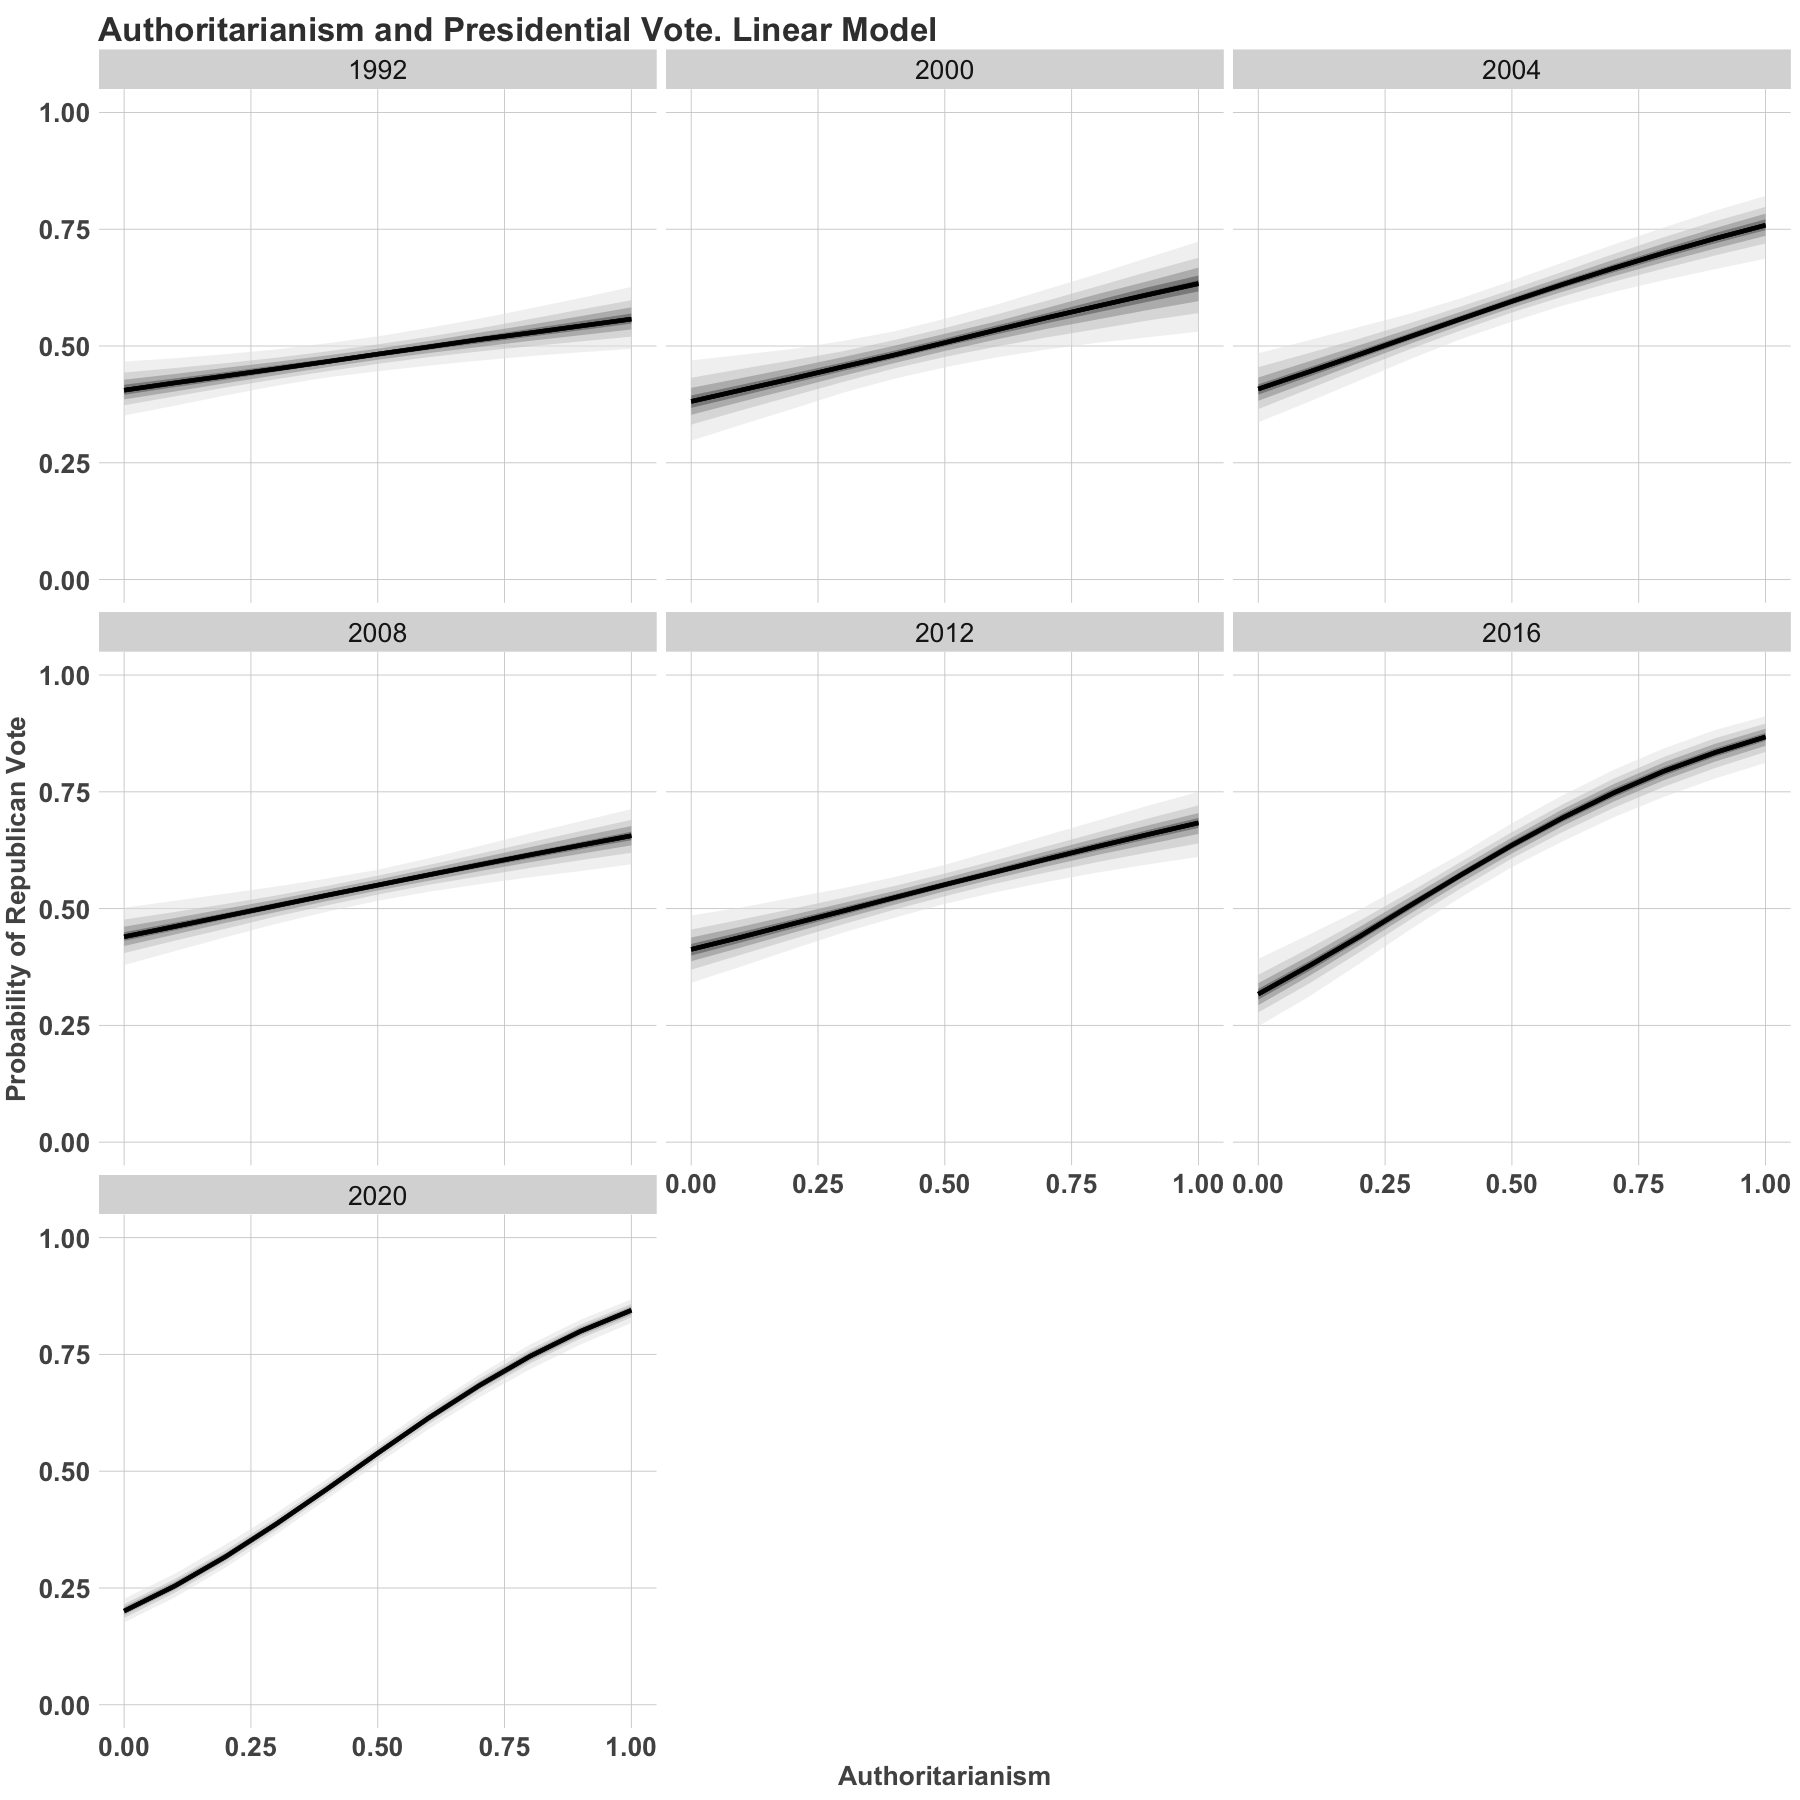

In [50]:
library(simplecolors)
## Pull out the relevant models from my output.
fit0b <- vote_models[[2]] # Random intercept model saved from models
fit1 <- vote_models[[3]] # Random slope mode saved fro model, linear

## Expand the data used to estimate this model
fixed_data <- data[, c(
     "vote", "authoritarianism",
     "female", "age", "college", "income",
     "jewish", "catholic", "other", "year"
)] %>%
     na.omit() %>%
     mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
     group_by(year) %>%
     data_grid(
          female = mean(female), age = mean(age),
          college = mean(college), income = mean(income),
          catholic = mean(catholic), jewish = mean(jewish),
          other = mean(other), authoritarianism = seq_range(authoritarianism, n = 11)
     ) %>%
     mutate(authoritarianism_2 = authoritarianism * authoritarianism)


m0 <- fixed_data %>%
     add_linpred_draws(fit0b) %>%
     mutate(Vote_Republican = plogis(.linpred)) ## Expand posterior

options(repr.plot.width = 15, repr.plot.height = 15)

## Plot linear Effects
m0 %>%
     ggplot(aes(x = authoritarianism)) +
     facet_wrap(~year) +
     stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1), alpha = 0.5) +
     scale_fill_manual(values = sc_grey(light = 1:5)) +
     # Format the grid
     ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
     scale_y_continuous("Probability of Republican Vote", limits = c(0, 1)) +
     scale_x_continuous("Authoritarianism") +
     ggtheme +
     theme(legend.title = element_blank()) +
     theme(legend.position = "none") %>%
     suppressWarnings()


Here's the quadratic specification. This should serve as **Figure 1** in Chapter 6.

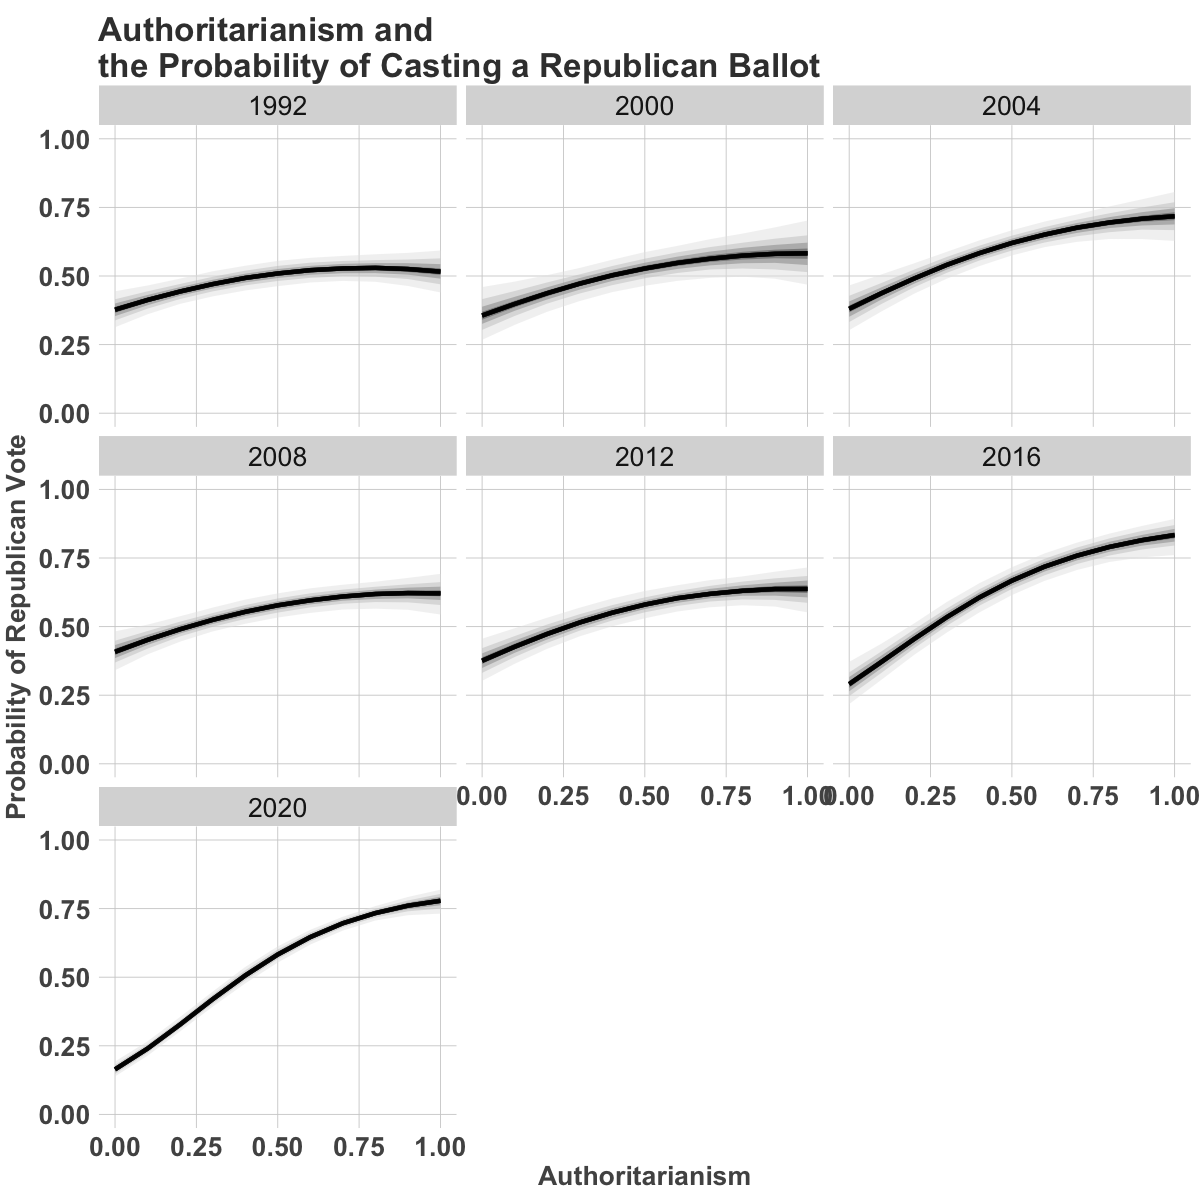

In [51]:
m1 <- fixed_data %>%
     add_linpred_draws(fit1) %>%
     mutate(Vote_Republican = plogis(.linpred)) ## Expand posterior

options(repr.plot.width = 10, repr.plot.height = 10)

## Plot linear Effects
m1 %>% ggplot(aes(x = authoritarianism)) +
     facet_wrap(~year) +
     stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1), alpha = 0.5) +
     scale_fill_manual(values = sc_grey(light = 1:5)) +
     # Format the grid
     ggtitle("Authoritarianism and \nthe Probability of Casting a Republican Ballot") +
     scale_y_continuous("Probability of Republican Vote", limits = c(0, 1)) +
     scale_x_continuous("Authoritarianism") +
     ggtheme +
     theme(legend.title = element_blank()) +
     theme(legend.position = "none")


In [52]:
fixed_data %>%
    add_linpred_draws(fit1) %>%
    mutate(Vote_Republican = plogis(.linpred)) %>%
    filter(authoritarianism == 1 | authoritarianism == 0) %>%
    group_by(year, authoritarianism) %>%
    summarize(pred = mean(Vote_Republican))
## Expand posterior


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,authoritarianism,pred
<dbl>,<dbl>,<dbl>
1992,0,0.3772407
1992,1,0.5163490
2000,0,0.3580679
2000,1,0.5818862
2004,0,0.3802563
2004,1,0.7172905
2008,0,0.4090466
2008,1,0.6207741
2012,0,0.3765646


# Cross Validation

What model provides a better fit? A useful way to get at this -- due in part to the non-nested nature of the models -- is "leave-one-out" validation. Basically estimate the model on some subset of the data, predict the model on the "hold-out" data, and compare.  

In [53]:
# Generate an expanded dataset varying levels of authoritarianism at fixed covariates.
### linear model (fit0b) ###
fit0a <- vote_models[[1]]
fit0b <- vote_models[[2]]
fit1 <- vote_models[[3]]

loo(fit0a, fit0b, fit1)


Output of model 'fit0a':

Computed from 1500 by 6023 log-likelihood matrix

         Estimate   SE
elpd_loo  -3785.4 26.7
p_loo        14.5  0.2
looic      7570.8 53.4
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit0b':

Computed from 1500 by 6023 log-likelihood matrix

         Estimate   SE
elpd_loo  -3716.1 28.7
p_loo        20.1  0.3
looic      7432.2 57.4
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit1':

Computed from 1500 by 6023 log-likelihood matrix

         Estimate   SE
elpd_loo  -3703.5 28.9
p_loo        24.0  0.4
looic      7407.1 57.9
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Model comparisons:
      elpd_diff se_diff
fit1    0.0       0.0  
fit0b -12.6       5.4  
fit0a -81.

The quadratic model is a reasonably good improvement over the lienar model (fit0b) and substantially better than the random-intercept, authoritarianism-has-a-fixed-effect model (fit0a).

# Marginal Effects

Below are the marginal effects. I'll show the linear effects, but throughout the remaining analysis, I just present the quadratic. As you can see here, there really isn't a large difference

### The Linear Variable Model

In [54]:
library(dplyr)
### Model to estimate AME
expanded_dat_0 <- fixed_data %>%
    group_by(year) %>%
    mutate(authoritarianism = quantile(authoritarianism, 0.025)) %>%
    add_linpred_draws(fit0b, draws = 1000) %>%
    mutate(low_auth = .linpred)

expanded_dat_1 <- fixed_data %>%
    group_by(year) %>%
    mutate(authoritarianism = quantile(authoritarianism, 0.975)) %>%
    add_linpred_draws(fit0b, draws = 1000) %>%
    mutate(high_auth = .linpred) %>%
    select(high_auth)

expanded_dat_0$high_auth <- expanded_dat_1$high_auth
expanded_dat_0$marginal <- plogis(expanded_dat_0$high_auth) - plogis(expanded_dat_0$low_auth)

marginals <- expanded_dat_0 %>%
    group_by(year) %>%
    mutate(min = quantile(marginal, 0.025)) %>%
    mutate(med = quantile(marginal, 0.50)) %>%
    mutate(max = quantile(marginal, 0.975)) %>%
    summarize(
        min = quantile(min, 0.025),
        med = quantile(med, 0.50),
        max = quantile(max, 0.975)
    )
marginals


Adding missing grouping variables: `year`, `female`, `age`, `college`,
`income`, `catholic`, `jewish`, `other`, `authoritarianism`,
`authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.04752058,0.1423105,0.2416158
2000,0.08413491,0.2379501,0.3866609
2004,0.21347673,0.3357143,0.4440231
2008,0.10585197,0.2048410,0.3016346
2012,0.14023753,0.2575502,0.3712468
2016,0.41844638,0.5264238,0.6235919
2020,0.57635008,0.6213057,0.6648771


### The Quadratic Variable Specification

In [55]:
### Model to estimate AME
expanded_dat_0 <- fixed_data %>%
    group_by(year) %>%
    mutate(authoritarianism = quantile(authoritarianism, 0.025)) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    data.frame() %>%
    add_linpred_draws(fit1, draws = 1000) %>%
    mutate(low_auth = .linpred)

expanded_dat_1 <- fixed_data %>%
    group_by(year) %>%
    mutate(authoritarianism = quantile(authoritarianism, 0.975)) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    data.frame() %>%
    add_linpred_draws(fit1, draws = 1000) %>%
    mutate(high_auth = .linpred) %>%
    select(high_auth)

expanded_dat_0$high_auth <- expanded_dat_1$high_auth
expanded_dat_0$marginal <- plogis(expanded_dat_0$high_auth) - plogis(expanded_dat_0$low_auth)

marginals_q <- expanded_dat_0 %>%
    group_by(year) %>%
    mutate(min = quantile(marginal, 0.025)) %>%
    mutate(med = quantile(marginal, 0.50)) %>%
    mutate(max = quantile(marginal, 0.975)) %>%
    summarize(
        min = quantile(min, 0.025),
        med = quantile(med, 0.50),
        max = quantile(max, 0.975)
    )
marginals_q


Adding missing grouping variables: `year`, `female`, `age`, `college`,
`income`, `catholic`, `jewish`, `other`, `authoritarianism`,
`authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.03697212,0.1309263,0.2306743
2000,0.05924761,0.2146100,0.3656828
2004,0.19624492,0.3219047,0.4363947
2008,0.09783481,0.2030296,0.2948736
2012,0.12418528,0.2479575,0.3641266
2016,0.40939501,0.5189562,0.6164301
2020,0.53846532,0.5928731,0.6372240


Here are the marginal effects in plot format. This should form **Figure 2**.

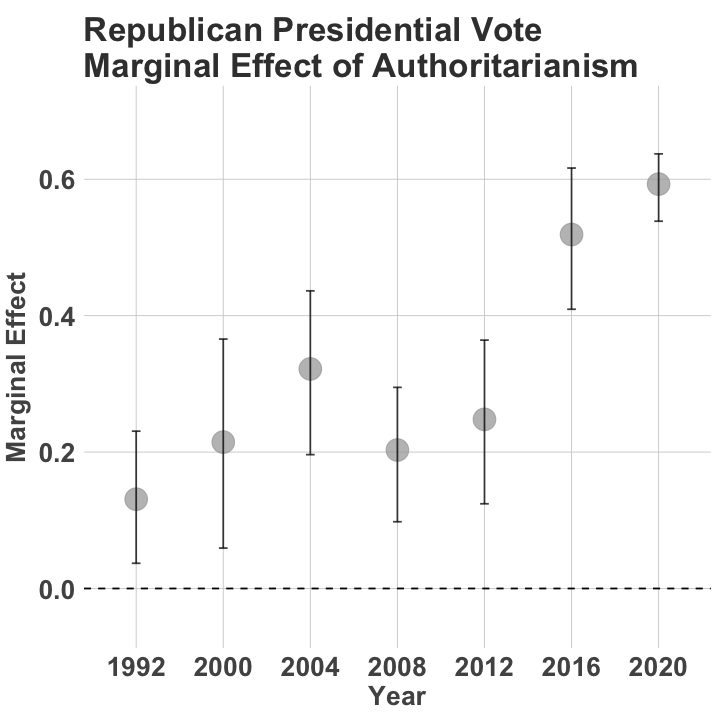

In [56]:
## Marginal Efffects plot for quadratic
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(
  data = marginals_q,
  aes(
    x = factor(year),
    y = med, ymin = max,
    ymax = min
  )
) +
  geom_point(size = 6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha = 0.75, colour = "black") +
  ggtitle("Republican Presidential Vote\nMarginal Effect of Authoritarianism") +
  ggtheme +
  scale_y_continuous("Marginal Effect", limits = c(-.05, 0.70)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed")


This figure forms Figure 2 in the chapter.

## Education x Authoritarianism 

Here are the effects disaggregated by education. Some of it is new, and I think the marginal effect plot is particularly useful. I'm not sure where to present this -- I think the predictive plots make more sense for the concluding part of this chapter. Maybe we put this plot in an appendix.

In [57]:
## Marginal Effects Function -- adapt to more complicated interactions
library(dplyr)
fixed <- data[, c(
  "vote", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  na.omit()
marginal_by_ed <- function(fixed = fixed, model_fit = education) {
  out1 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = quantile(authoritarianism, 0.025)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  out2 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = quantile(authoritarianism, .975)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  r <- fixed %>%
    na.omit() %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other),
      authoritarianism = quantile(authoritarianism, 0.025)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100)
  r$marginal <- out2$.epred - out1$.epred
  return(r)
}


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


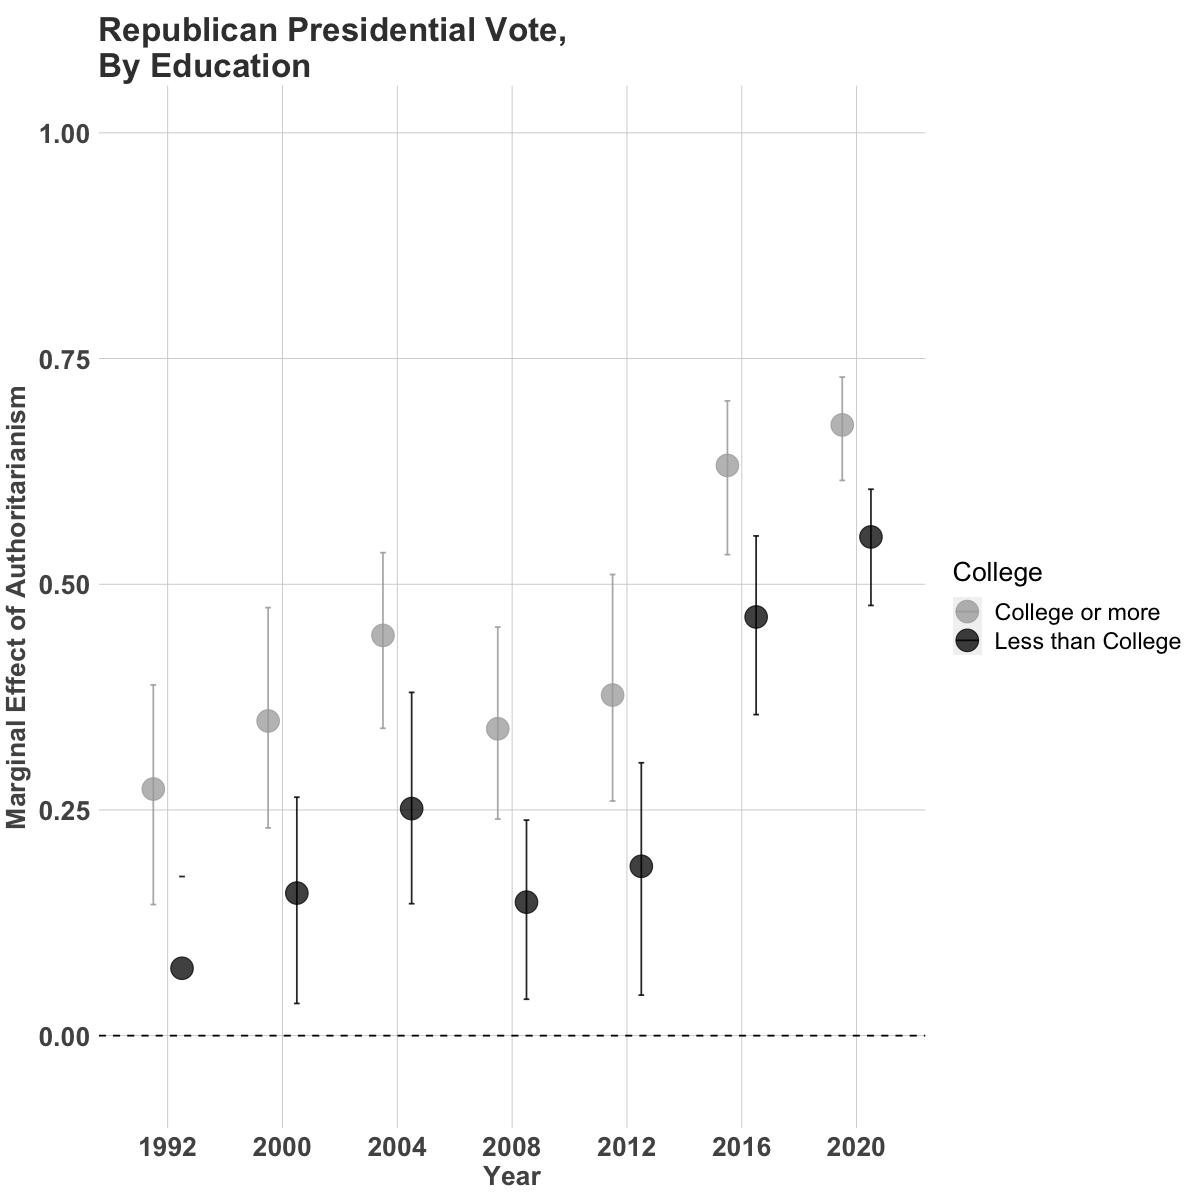

In [58]:
options(repr.plot.width = 10, repr.plot.height = 10)

education <- vote_models[[4]]

marginal_by_ed(fixed = fixed) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    group_by(year, Education) %>%
    mutate(min = quantile(marginal, 0.025)) %>%
    mutate(med = quantile(marginal, 0.50)) %>%
    mutate(max = quantile(marginal, 0.975)) %>%
    summarize(
        min = quantile(min, 0.025),
        med = quantile(med, 0.50),
        max = quantile(max, 0.975)
    ) %>%
    ggplot(aes(
        x = factor(year),
        y = med, ymin = max,
        ymax = min, colour = as.factor(Education), group = as.factor(Education)
    )) +
    geom_point(size = 6, alpha = 0.75, position = position_dodge(width = 0.5)) +
    geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
    ggtitle("Republican Presidential Vote,\nBy Education") +
    ggtheme +
    scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.05, 1)) +
    scale_x_discrete("Year") +
    geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black"))


Here is the predictive plot. I think it's a bit more forceful. The slope is noticeably flatter for the less-educated, particularly pre 2016.

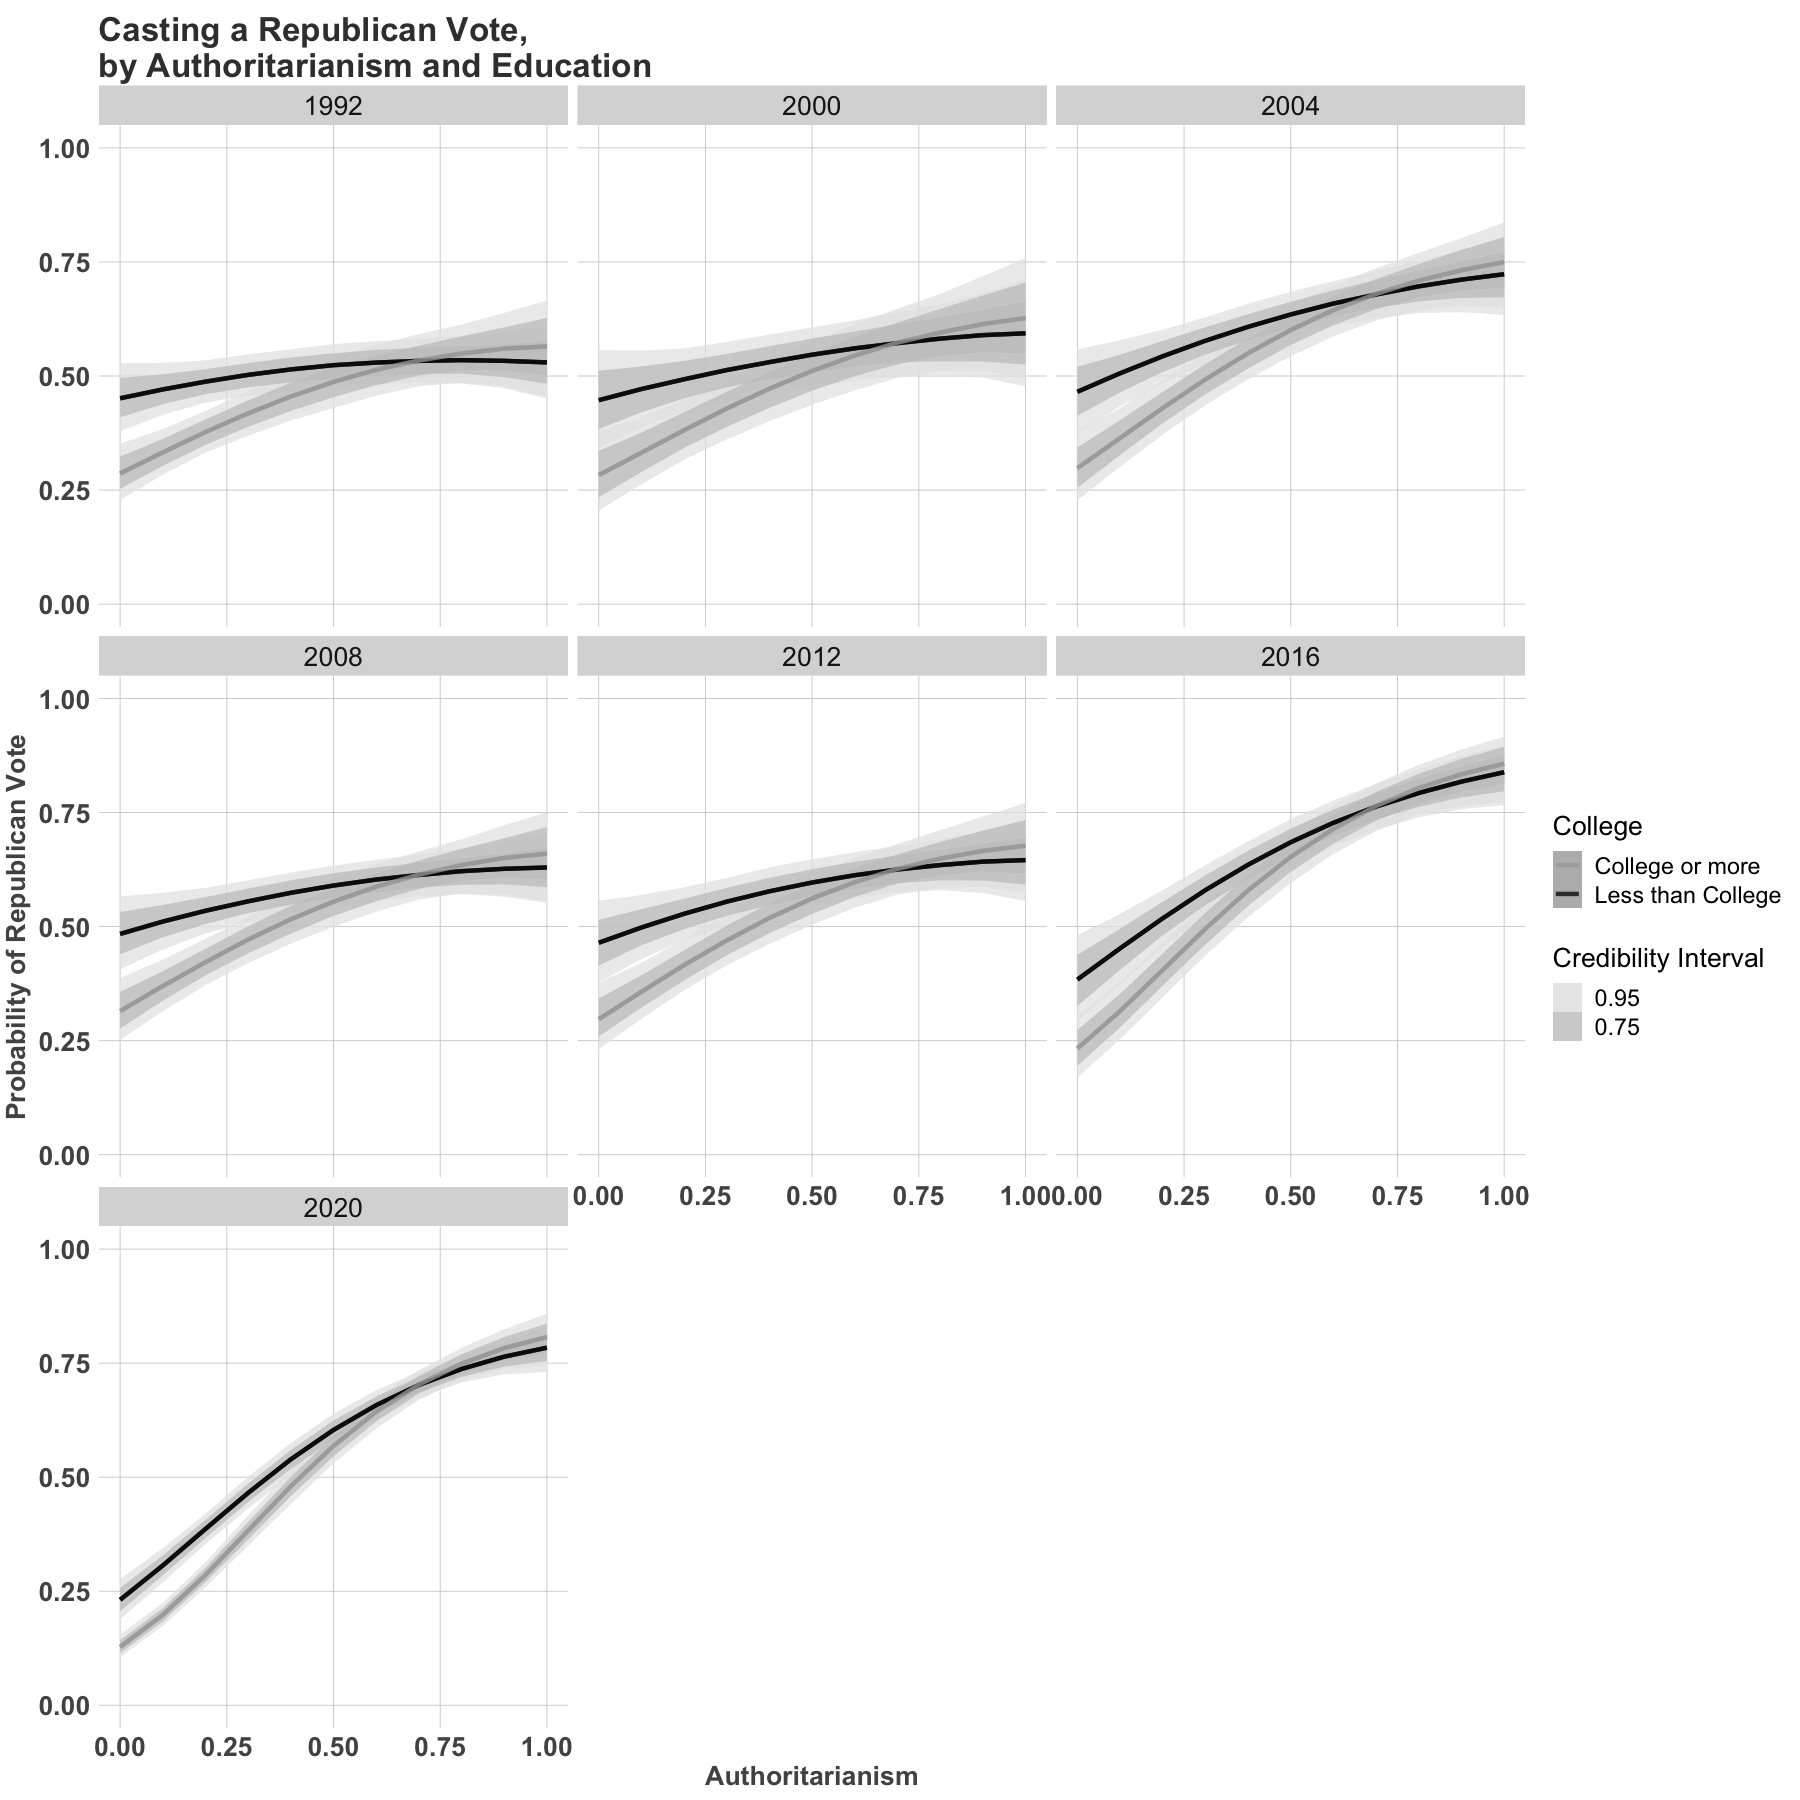

In [92]:
education <- vote_models[[4]]

fixed_data <- data[, c(
      "vote", "authoritarianism",
      "female", "age", "college", "income",
      "jewish", "catholic", "other", "year"
)] %>%
      na.omit() %>%
      mutate(authoritarianism_2 = authoritarianism * authoritarianism)

model1 <- fixed_data %>%
      group_by(year) %>%
      data_grid(
            female = mean(female), age = mean(age),
            college = c(0, 1), income = mean(income),
            catholic = mean(catholic), jewish = mean(jewish),
            other = mean(other),
            authoritarianism = seq_range(authoritarianism, n = 11)
      ) %>%
      mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
      group_by(year) %>%
      add_linpred_draws(education) %>%
      mutate(Vote_Republican = plogis(.linpred)) %>%
      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more"))


options(repr.plot.width = 15, repr.plot.height = 15)

model1 %>% ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) +
      facet_wrap(~year) +
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75), alpha = 0.75) +
      ggtheme +
      scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
      # Format the grid
      ggtitle("Casting a Republican Vote,\nby Authoritarianism and Education") +
      scale_y_continuous("Probability of Republican Vote", limits = c(0, 1)) +
      scale_x_continuous("Authoritarianism") +
      scale_colour_manual(name = "College", values = c("darkgrey", "black"))


In [60]:
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 11)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(education) %>%
  mutate(Vote_Republican = plogis(.linpred)) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  filter(authoritarianism == 1 | authoritarianism == 0) %>%
  group_by(Education, year, authoritarianism) %>%
  summarize(out = mean(Vote_Republican))


`summarise()` has grouped output by 'Education', 'year'. You can override using
the `.groups` argument.


Education,year,authoritarianism,out
<chr>,<dbl>,<dbl>,<dbl>
College or more,1992,0,0.2874750
College or more,1992,1,0.5643382
College or more,2000,0,0.2846582
College or more,2000,1,0.6270251
College or more,2004,0,0.2994035
College or more,2004,1,0.7484530
College or more,2008,0,0.3160032
College or more,2008,1,0.6605918
College or more,2012,0,0.2991105


# Affective Polarization

Here are the bar plots for our affective analysis plots (Figures 3,4)

`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


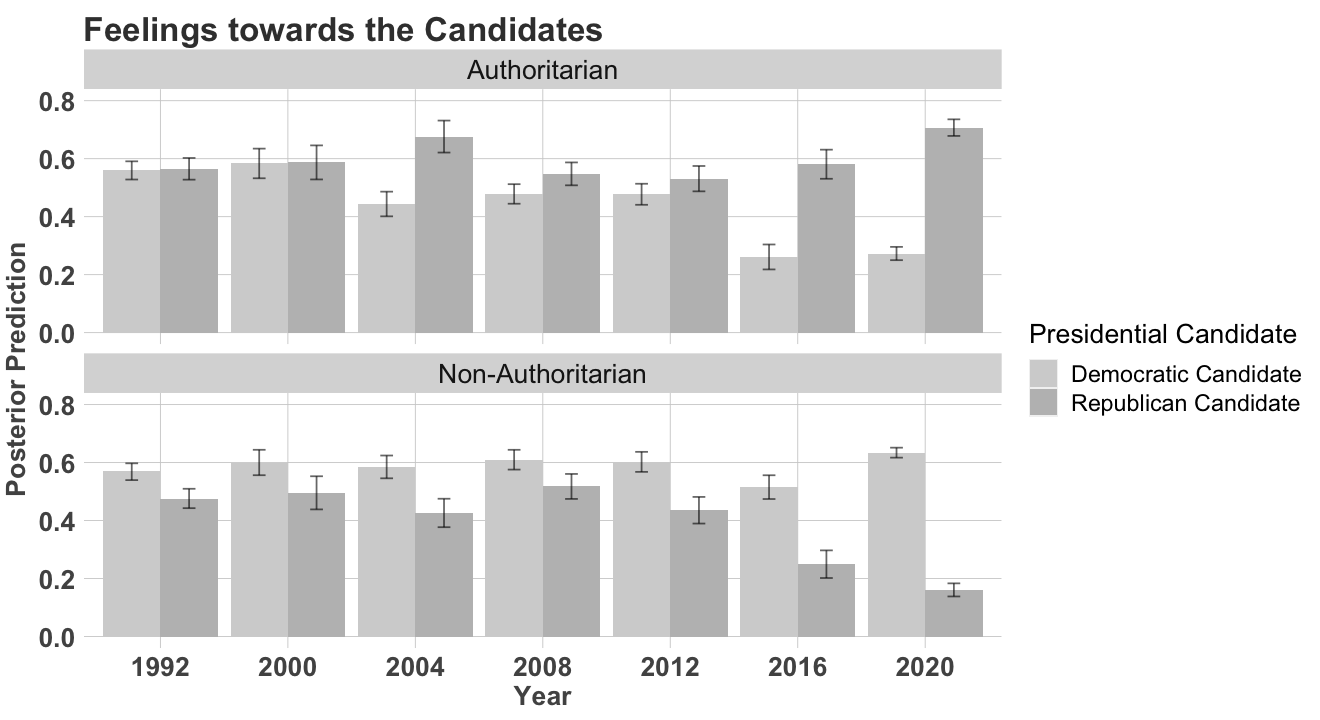

In [61]:
options(repr.plot.width = 11, repr.plot.height = 6)
data$party3 <- recode(data$pid * 6 + 1, `1` = 1, `2` = 1, `3` = 2, `4` = 2, `5` = 2, `6` = 3, `7` = 3) %>% suppressWarnings()
data$republican <- recode(data$pid * 6 + 1, `1` = 0, `2` = 0, `3` = 0, `4` = 0, `5` = 0, `6` = 1, `7` = 1) %>% suppressWarnings()
data$democrat <- recode(data$pid * 6 + 1, `1` = 1, `2` = 1, `3` = 0, `4` = 0, `5` = 0, `6` = 0, `7` = 0) %>% suppressWarnings()
data$independent <- recode(data$pid * 6 + 1, `1` = 0, `2` = 0, `3` = 1, `4` = 1, `5` = 1, `6` = 0, `7` = 0) %>% suppressWarnings()
dems <- affect[[1]]
reps <- affect[[2]]
demc <- affect[[3]]
repc <- affect[[4]]

fixed_data <- data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism)

data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  ) %>%
  as_tibble() %>%
  filter(.group %in% c("Democratic Candidate", "Republican Candidate")) %>%
  ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y = mean, fill = .group), stat = "identity", position = position_dodge()) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(name = "Presidential Candidate", values = c("lightgrey", "grey")) +
  geom_errorbar(width = .2, position = position_dodge(0.9), alpha = 0.6) +
  facet_wrap(~Authoritarianism, nrow = 2) +
  ggtitle("Feelings towards the Candidates") +
  scale_y_continuous("Posterior Prediction", limits = c(0, 0.8)) +
  ggtheme +
  scale_x_discrete("Year")


`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


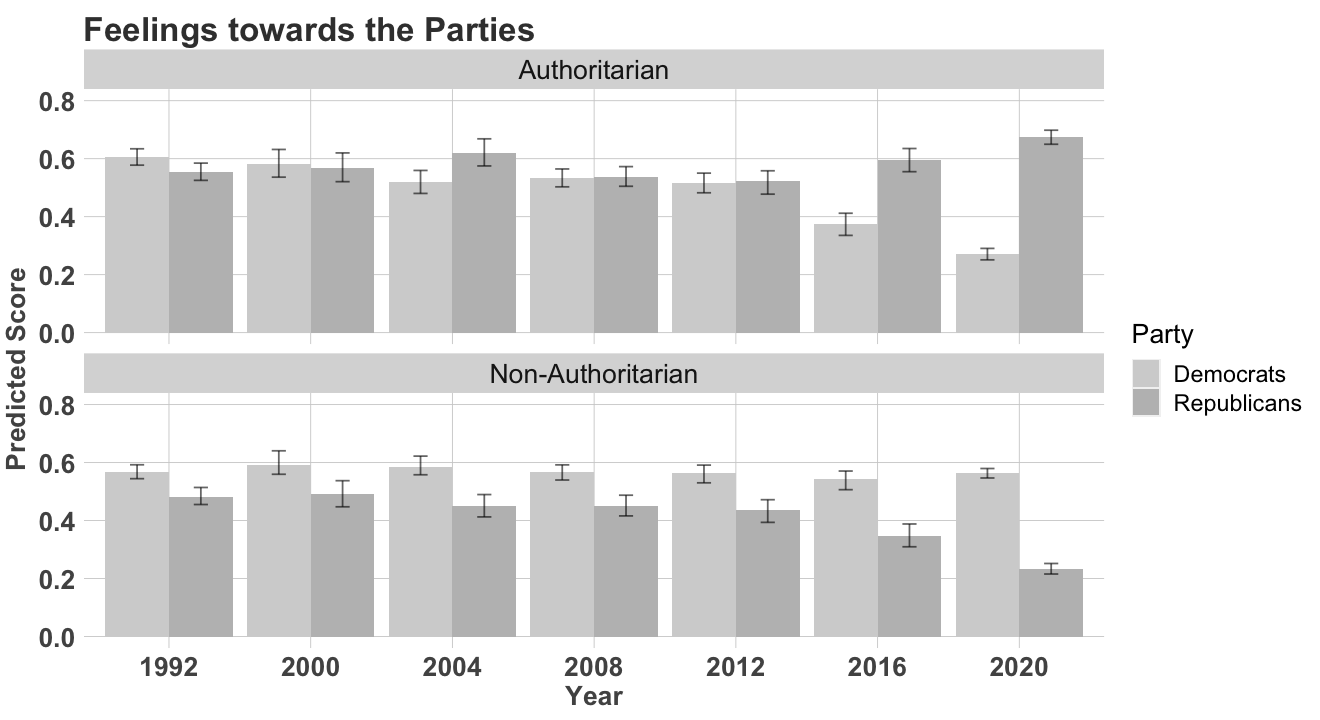

In [62]:
options(repr.plot.width = 11, repr.plot.height = 6)

data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican_Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic_Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  ) %>%
  as_tibble() %>%
  filter(.group %in% c("Democrats", "Republicans")) %>%
  ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y = mean, fill = .group), stat = "identity", position = position_dodge()) +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(name = "Party", values = c("lightgrey", "grey")) +
  geom_errorbar(width = .2, position = position_dodge(0.9), alpha = 0.6) +
  facet_wrap(~Authoritarianism, nrow = 2) +
  ggtitle("Feelings towards the Parties") +
  scale_y_continuous("Predicted Score", limits = c(0, 0.8)) +
  ggtheme +
  scale_x_discrete("Year")


In [63]:

data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican_Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic_Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  )


`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


.group,Authoritarianism,year,mean,min,max
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Democratic_Candidate,Authoritarian,1992,0.5594789,0.5281296,0.5908362
Democratic_Candidate,Authoritarian,2000,0.5848761,0.5323471,0.6346411
Democratic_Candidate,Authoritarian,2004,0.4449954,0.4010996,0.4862290
Democratic_Candidate,Authoritarian,2008,0.4784632,0.4446136,0.5120306
Democratic_Candidate,Authoritarian,2012,0.4785090,0.4409288,0.5135012
Democratic_Candidate,Authoritarian,2016,0.2609794,0.2179573,0.3040138
Democratic_Candidate,Authoritarian,2020,0.2727289,0.2499136,0.2957739
Democratic_Candidate,Non-Authoritarian,1992,0.5695323,0.5394449,0.5973804
Democratic_Candidate,Non-Authoritarian,2000,0.5979196,0.5563696,0.6440372


In [98]:
## Write a function to calculate margins, main effects
margins <- function(fixed = fixed, model_fit) {
  out1 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = min(authoritarianism)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  out2 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = max(authoritarianism)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  r <- fixed %>%
    na.omit() %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other),
      authoritarianism = 0
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100)
  r$marginal <- out2$.epred - out1$.epred
  return(r)
}


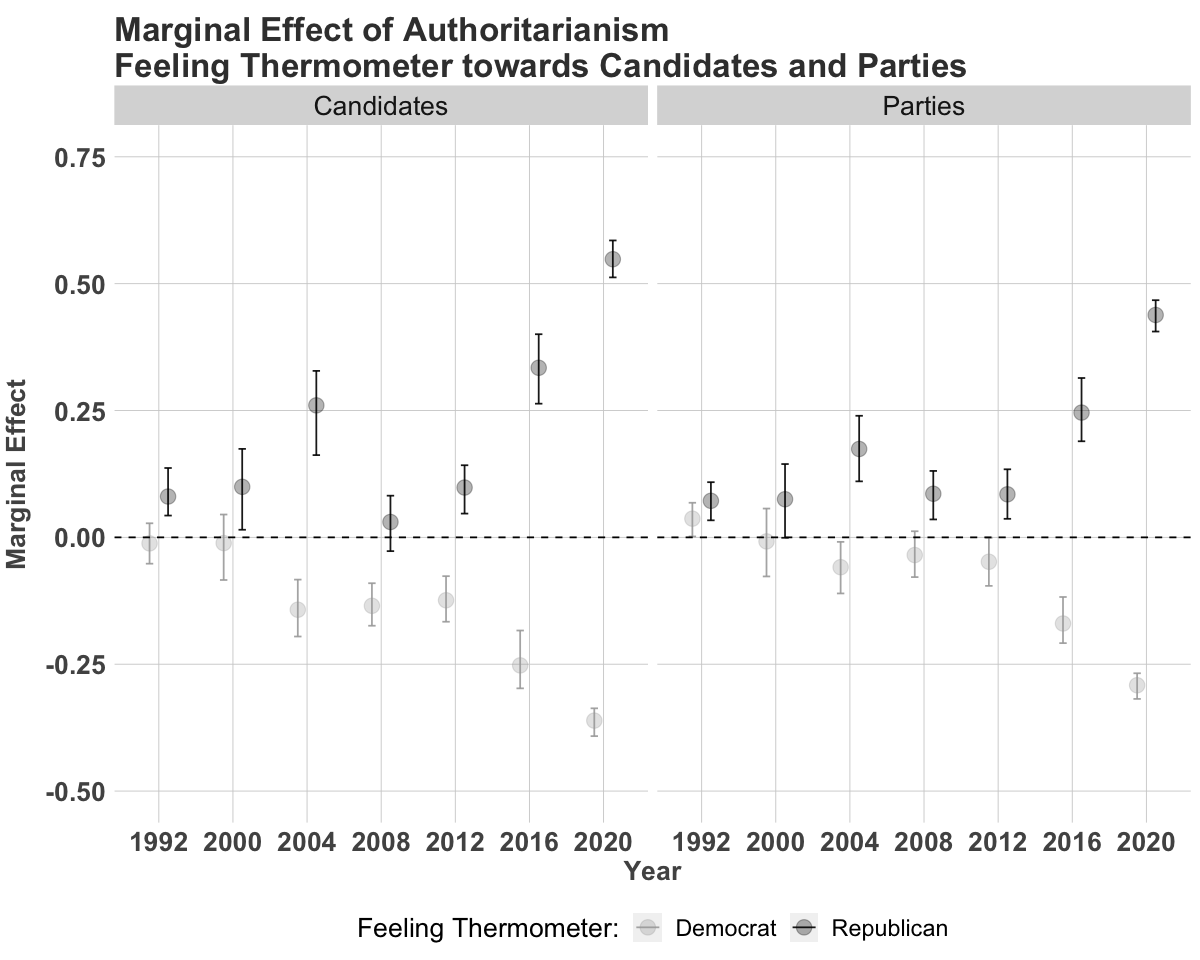

In [99]:
options(repr.plot.width = 10, repr.plot.height = 8)

data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republicans"),
    margins(fixed_data, model_fit = dems) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democratic_Candidate")
)) %>%
    mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>%
    mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidates", "Parties")) %>%
    ggplot(aes(
        x = factor(year),
        y = mean, ymin = min,
        ymax = max, colour = as.factor(pid), group = as.factor(pid)
    )) +
    facet_wrap(~candidate, nrow = 1) +
    geom_point(size = 4, alpha = 0.3, position = position_dodge(width = 0.5)) +
    geom_errorbar(width = 0.20, alpha = 0.9, position = position_dodge(width = 0.5)) +
    ggtitle("Marginal Effect of Authoritarianism\nFeeling Thermometer towards Candidates and Parties") +
    ggtheme +
    scale_y_continuous("Marginal Effect", limits = c(-0.5, 0.75)) +
    scale_x_discrete("Year") +
    geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
    scale_colour_manual(name = "Feeling Thermometer:", values = c("darkgrey", "black")) +
    theme(legend.position = "bottom")


In [97]:
data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republicans"),
    margins(fixed_data, model_fit = dems) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democratic_Candidate")
))


year,mean,min,max,Party
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1992,0.068676823,0.031355077,0.1057333252,Republicans
2000,0.074128683,0.005348849,0.1381054709,Republicans
2004,0.168476151,0.118312511,0.2278367600,Republicans
2008,0.084185112,0.038052322,0.1341081060,Republicans
2012,0.086815673,0.032468009,0.1319725140,Republicans
2016,0.242792154,0.189206035,0.3031778954,Republicans
2020,0.439661104,0.403948752,0.4702647526,Republicans
1992,0.033979525,0.006230101,0.0711617898,Democrats
2000,-0.007265528,-0.063482190,0.0524692649,Democrats


In [37]:

data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republicans"),
    margins(fixed_data, model_fit = dems) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democratic_Candidate")
)) %>%
    mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>%
    mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidate", "Party"))


year,mean,min,max,Party,pid,candidate
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1992,0.067322155,0.030590723,0.112617278,Republicans,Republican,Party
2000,0.076013765,0.019278897,0.145863878,Republicans,Republican,Party
2004,0.172369001,0.096454960,0.230086517,Republicans,Republican,Party
2008,0.087974417,0.036816796,0.134459007,Republicans,Republican,Party
2012,0.086684369,0.045302099,0.139302346,Republicans,Republican,Party
2016,0.246180323,0.193429955,0.312387651,Republicans,Republican,Party
2020,0.440441780,0.407622890,0.468759677,Republicans,Republican,Party
1992,0.033835929,0.001182788,0.067511530,Democrats,Democrat,Party
2000,-0.012488026,-0.093929202,0.044568163,Democrats,Democrat,Party


I did change this figure a bit. Let me know what you think. It seems particularly striking with everything on one plot.

# Education and Affective Polarization

Here are calculate the effects of authoritarianism for REP FT - DEM FT and REP CAND FT - DEM CAND FT

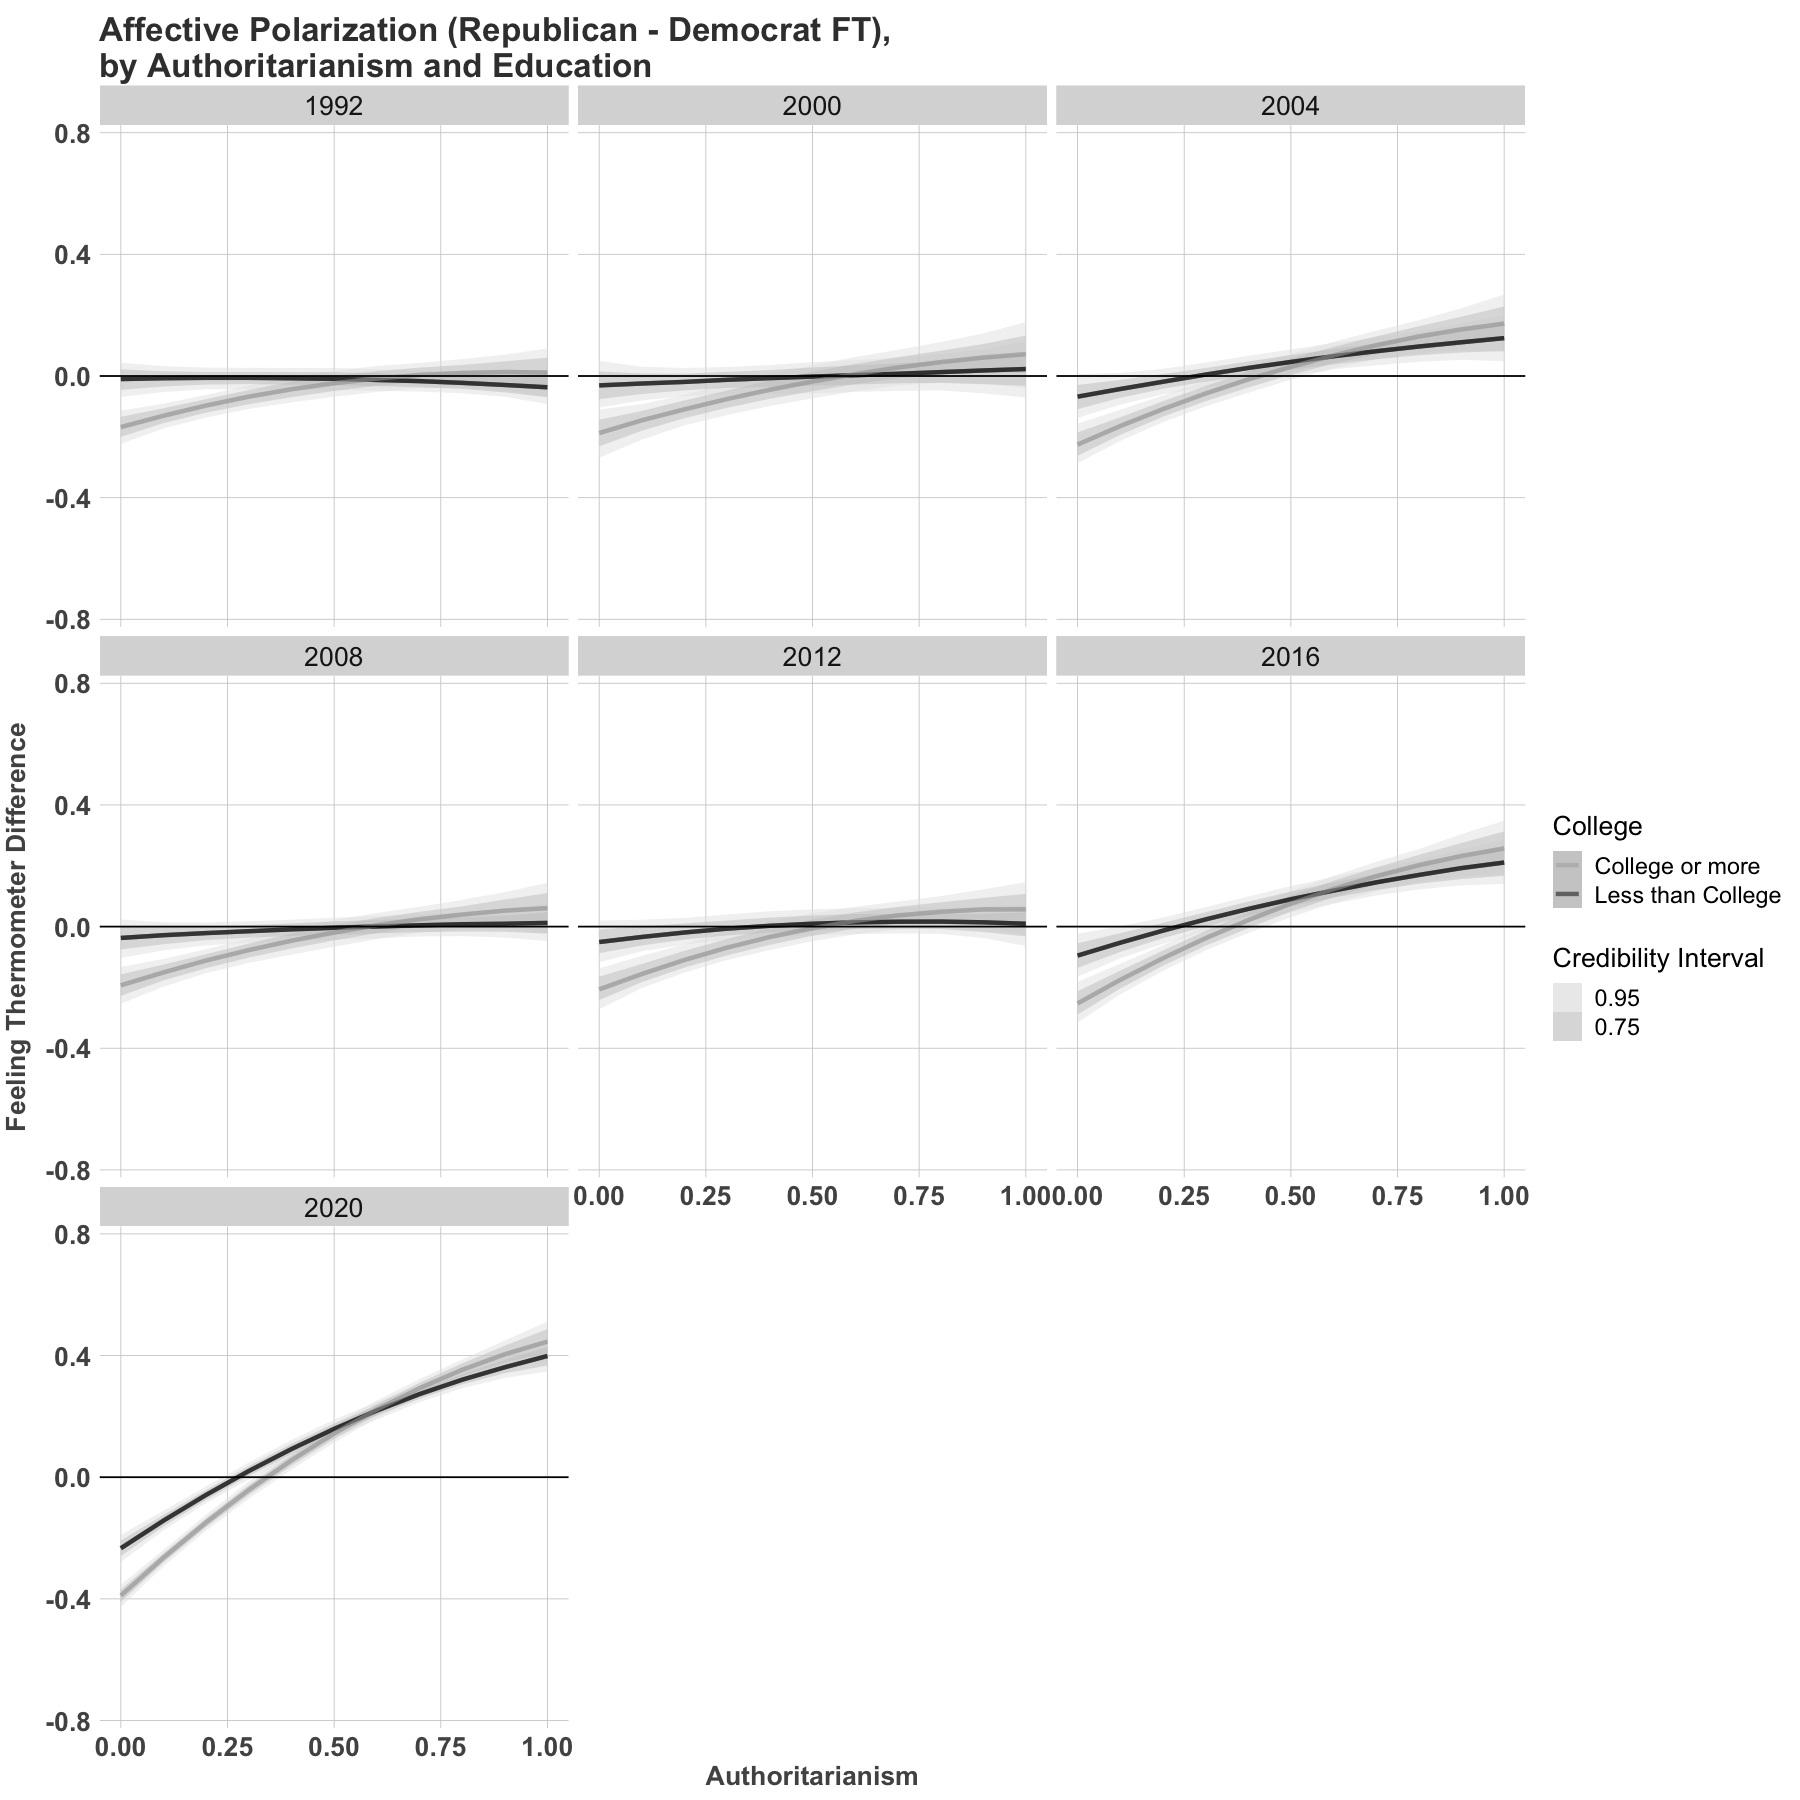

In [93]:
options(repr.plot.width = 15, repr.plot.height = 15)

difference <- affect[[5]]
fixed_data %>%
    group_by(year) %>%
    data_grid(
        female = mean(female), age = mean(age),
        college = c(0, 1), income = mean(income),
        catholic = mean(catholic), jewish = mean(jewish),
        other = mean(other),
        authoritarianism = seq_range(authoritarianism, n = 11)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    group_by(year) %>%
    add_linpred_draws(difference) %>%
    mutate(Feeling = .linpred) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) +
    facet_wrap(~year) +
    stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75), alpha = 0.5) +
    ggtheme +
    geom_hline(yintercept = 0) +
    scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
    # Format the grid
    ggtitle("Affective Polarization (Republican - Democrat FT),\nby Authoritarianism and Education") +
    scale_y_continuous("Feeling Thermometer Difference", limits = c(-0.75, 0.75)) +
    scale_x_continuous("Authoritarianism") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black"))


In [39]:
options(repr.plot.width = 15, repr.plot.height = 15)

difference <- affect[[5]]
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(difference) %>%
  mutate(Feeling = .linpred) %>%
  mutate(Education = recode(college,
    `0` = "Less than College",
    `1` = "College or more"
  )) %>%
  group_by(Education, authoritarianism, year) %>%
  summarise(
    mean = quantile(Feeling, prob = 0.5),
    min = quantile(Feeling, prob = 0.025),
    max = quantile(Feeling, prob = 0.975)
  )


`summarise()` has grouped output by 'Education', 'authoritarianism'. You can
override using the `.groups` argument.


Education,authoritarianism,year,mean,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
College or more,0,1992,-0.167882474,-0.22335471,-0.114170682
College or more,0,2000,-0.191369963,-0.27346738,-0.114805081
College or more,0,2004,-0.225982441,-0.28729794,-0.157627488
College or more,0,2008,-0.193354299,-0.25404942,-0.132384318
College or more,0,2012,-0.208027933,-0.27384729,-0.137784348
College or more,0,2016,-0.254363686,-0.31736384,-0.182571805
College or more,0,2020,-0.394106236,-0.43074332,-0.358051313
College or more,1,1992,0.011203810,-0.06949512,0.090757807
College or more,1,2000,0.068260331,-0.04409623,0.174097863


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


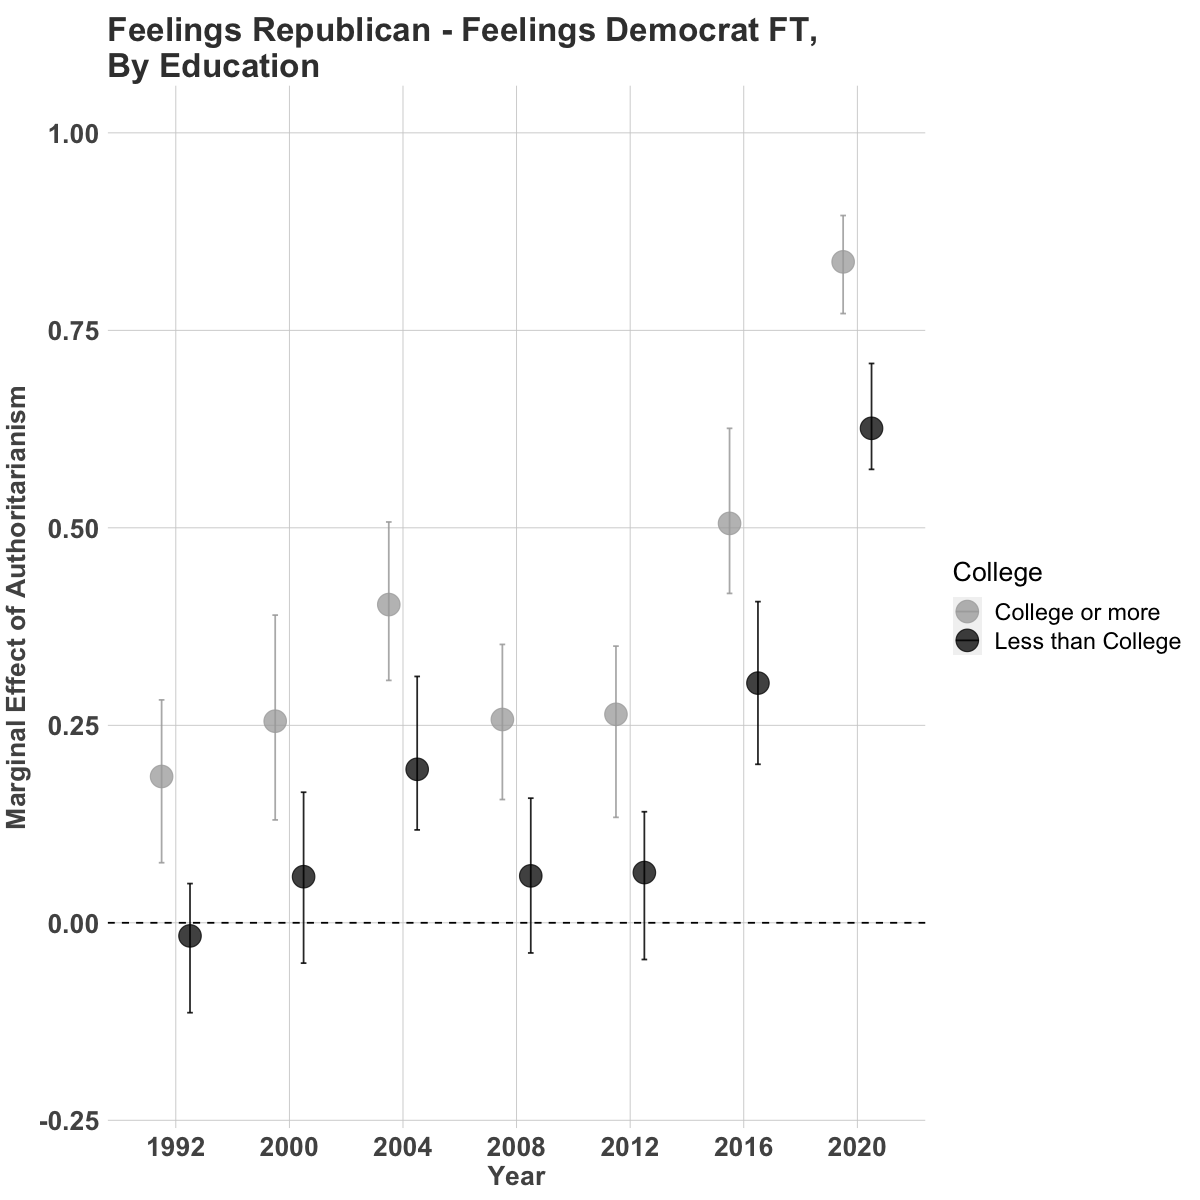

In [40]:
options(repr.plot.width = 10, repr.plot.height = 10)

marginal_by_ed(fixed = fixed, model_fit = difference) %>%
  group_by(year, college) %>%
  mutate(min = quantile(marginal, 0.025)) %>%
  mutate(med = quantile(marginal, 0.50)) %>%
  mutate(max = quantile(marginal, 0.975)) %>%
  summarize(
    min = quantile(min, 0.025),
    med = quantile(med, 0.50),
    max = quantile(max, 0.975)
  ) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  ggplot(aes(
    x = factor(year),
    y = med, ymin = max,
    ymax = min, colour = as.factor(Education), group = as.factor(Education)
  )) +
  geom_point(size = 6, alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Feelings Republican - Feelings Democrat FT,\nBy Education") +
  ggtheme +
  scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.2, 1)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "College", values = c("darkgrey", "black"))


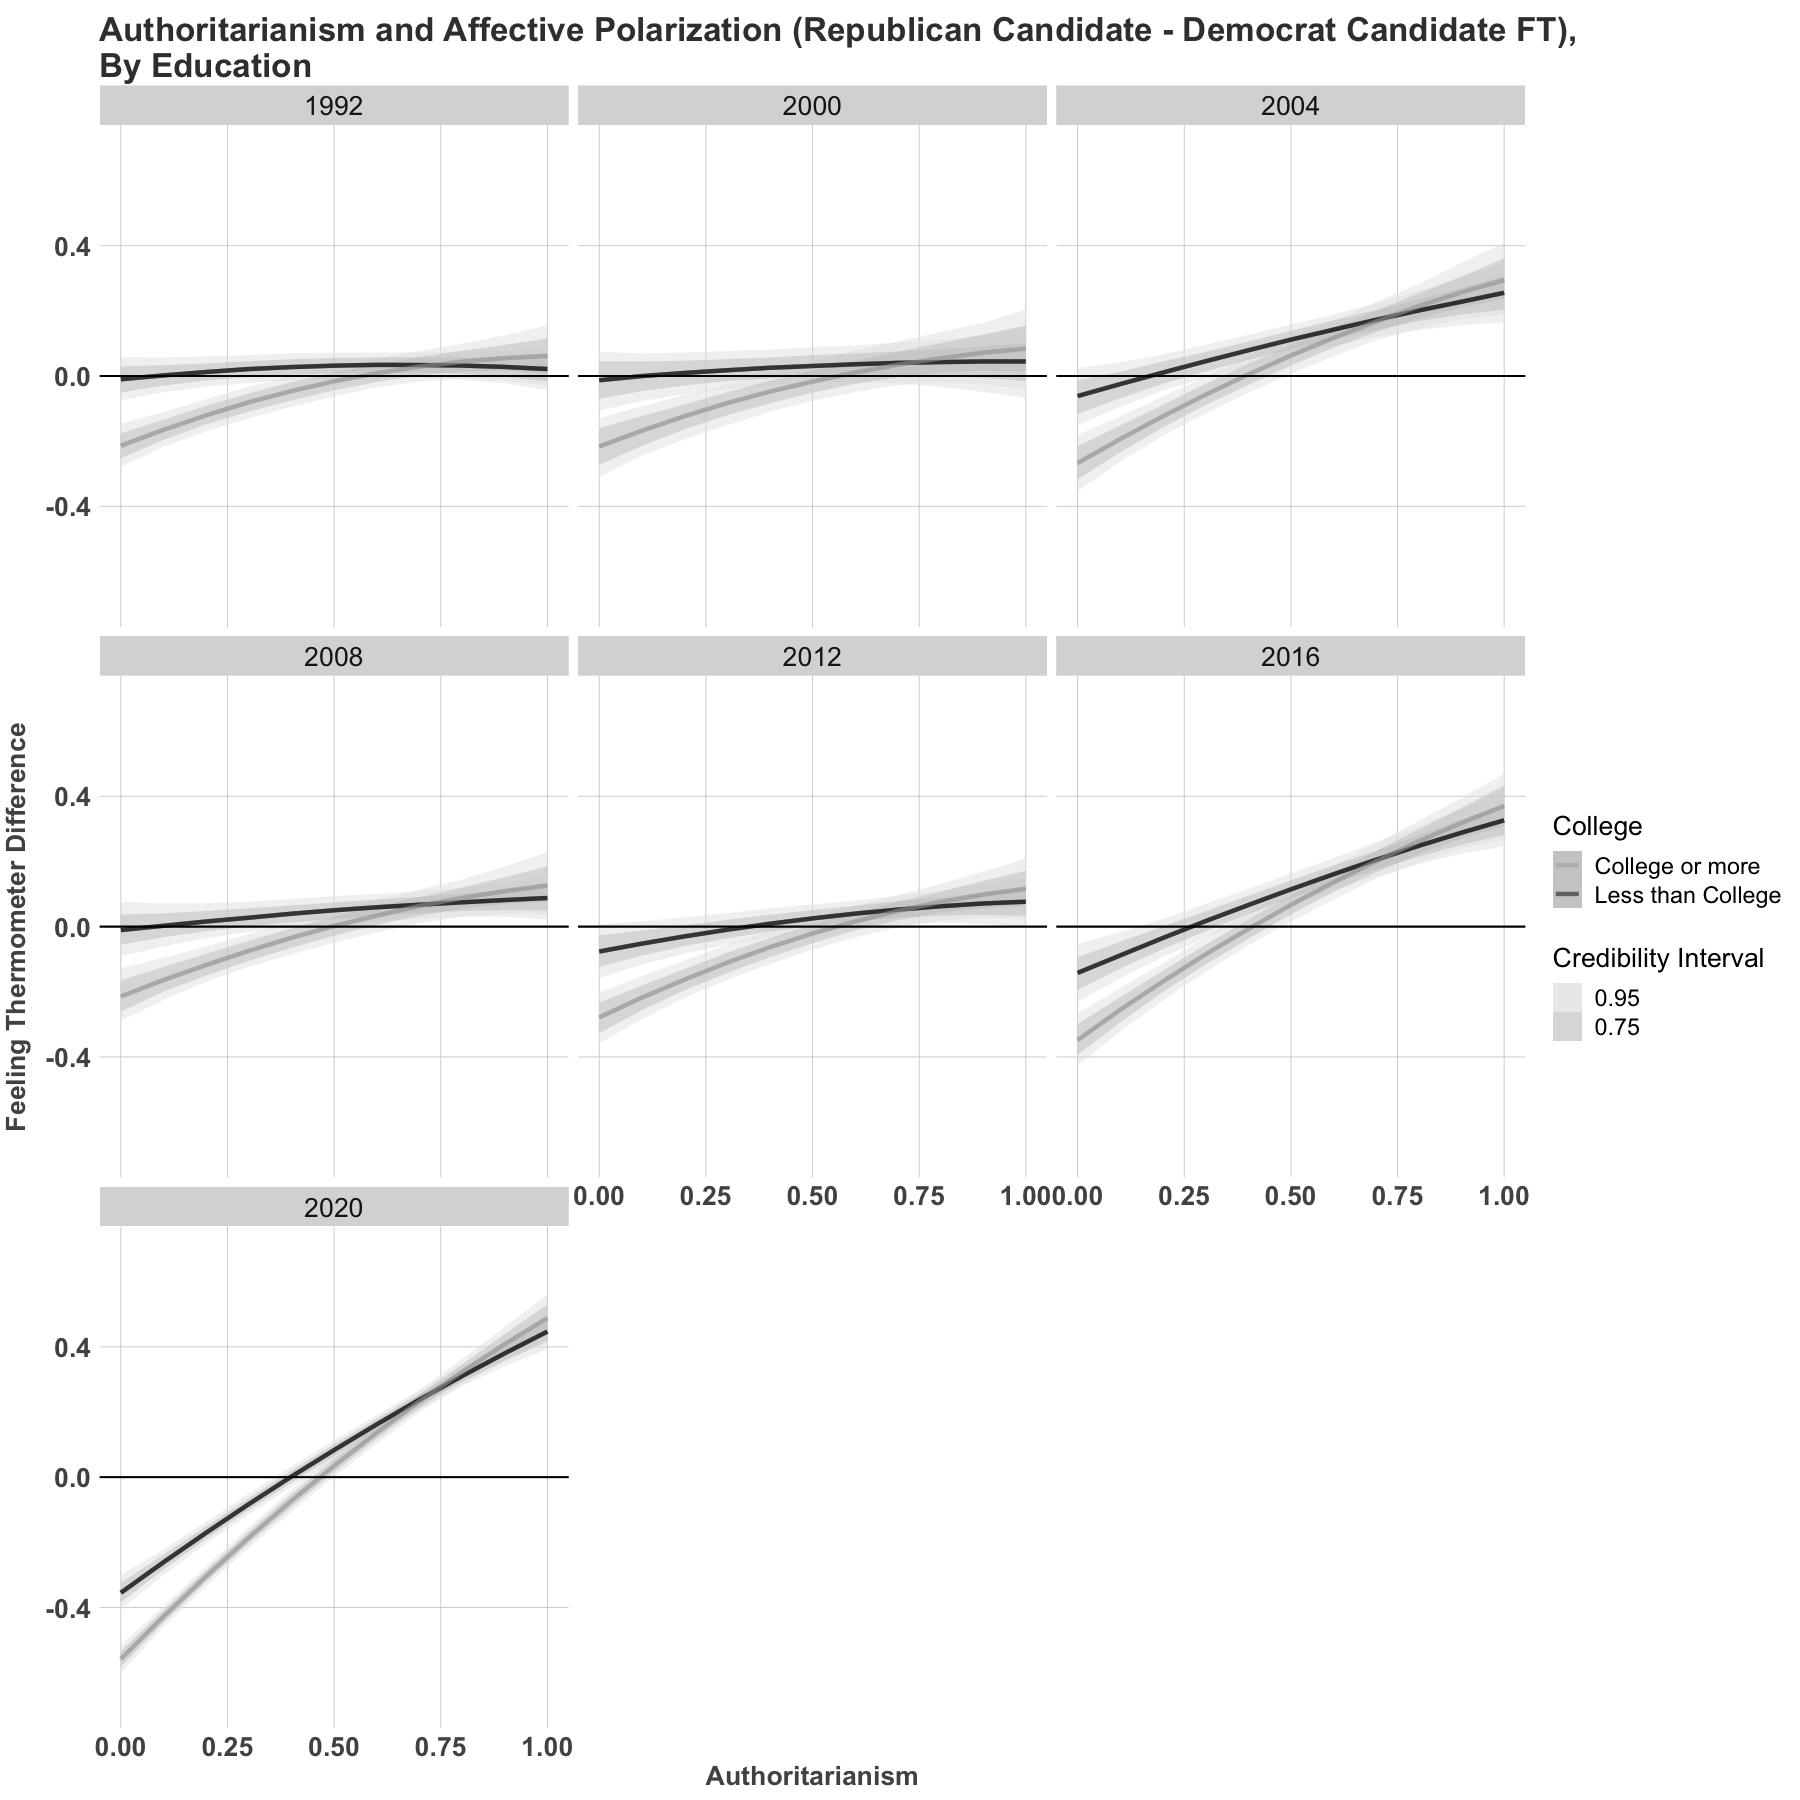

In [54]:
options(repr.plot.width = 15, repr.plot.height = 15)
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/affect2.rda")
fixed_data %>%
    group_by(year) %>%
    data_grid(
        female = mean(female), age = mean(age),
        college = c(0, 1), income = mean(income),
        catholic = mean(catholic), jewish = mean(jewish),
        other = mean(other),
        authoritarianism = seq_range(authoritarianism, n = 11)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    group_by(year) %>%
    add_linpred_draws(extremity2) %>%
    mutate(Feeling = .linpred) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) +
    facet_wrap(~year) +
    stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75), alpha = 0.5) +
    ggtheme +
    geom_hline(yintercept = 0) +
    geom_hline(yintercept = 0) +
    scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
    # Format the grid
    ggtitle("Authoritarianism and Affective Polarization (Republican Candidate - Democrat Candidate FT),\nBy Education") +
    scale_y_continuous("Feeling Thermometer Difference", limits = c(-0.7, 0.7)) +
    scale_x_continuous("Authoritarianism") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black"))


In [ ]:
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 11)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(education) %>%
  mutate(Vote_Republican = plogis(.linpred)) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  filter(authoritarianism == 1 | authoritarianism == 0) %>%
  group_by(Education, year, authoritarianism) %>%
  summarize(out = mean(Vote_Republican))


`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.
Warning message:
"Removed 1 rows containing missing values (geom_point)."


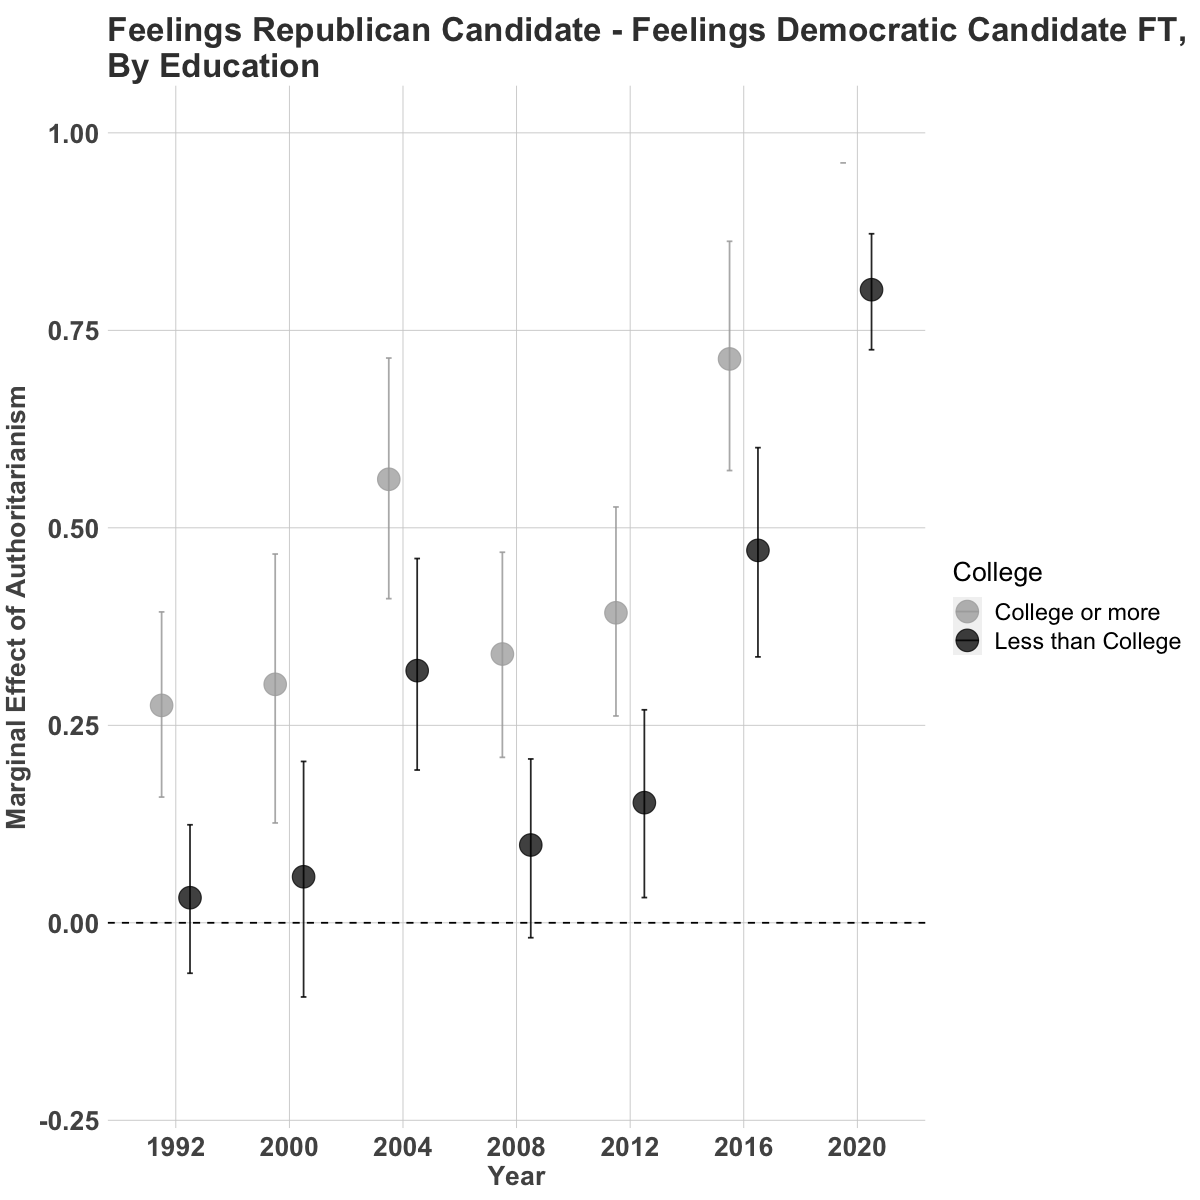

In [50]:
options(repr.plot.width = 10, repr.plot.height = 10)

marginal_by_ed(fixed = fixed, model_fit = extremity2) %>%
    group_by(year, college) %>%
    mutate(min = quantile(marginal, 0.025)) %>%
    mutate(med = quantile(marginal, 0.50)) %>%
    mutate(max = quantile(marginal, 0.975)) %>%
    summarize(
        min = quantile(min, 0.025),
        med = quantile(med, 0.50),
        max = quantile(max, 0.975)
    ) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    ggplot(aes(
        x = factor(year),
        y = med, ymin = max,
        ymax = min, colour = as.factor(Education), group = as.factor(Education)
    )) +
    geom_point(size = 6, alpha = 0.75, position = position_dodge(width = 0.5)) +
    geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
    ggtitle("Feelings Republican Candidate - Feelings Democratic Candidate FT,\nBy Education") +
    ggtheme +
    scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.2, 1)) +
    scale_x_discrete("Year") +
    geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black"))


Things do seem to change in 2016, 2020. There's really no effect of authoritarianism on affective polarization among non-college educated respondents before 2016

## Partisanship and Authoritarian Sorting

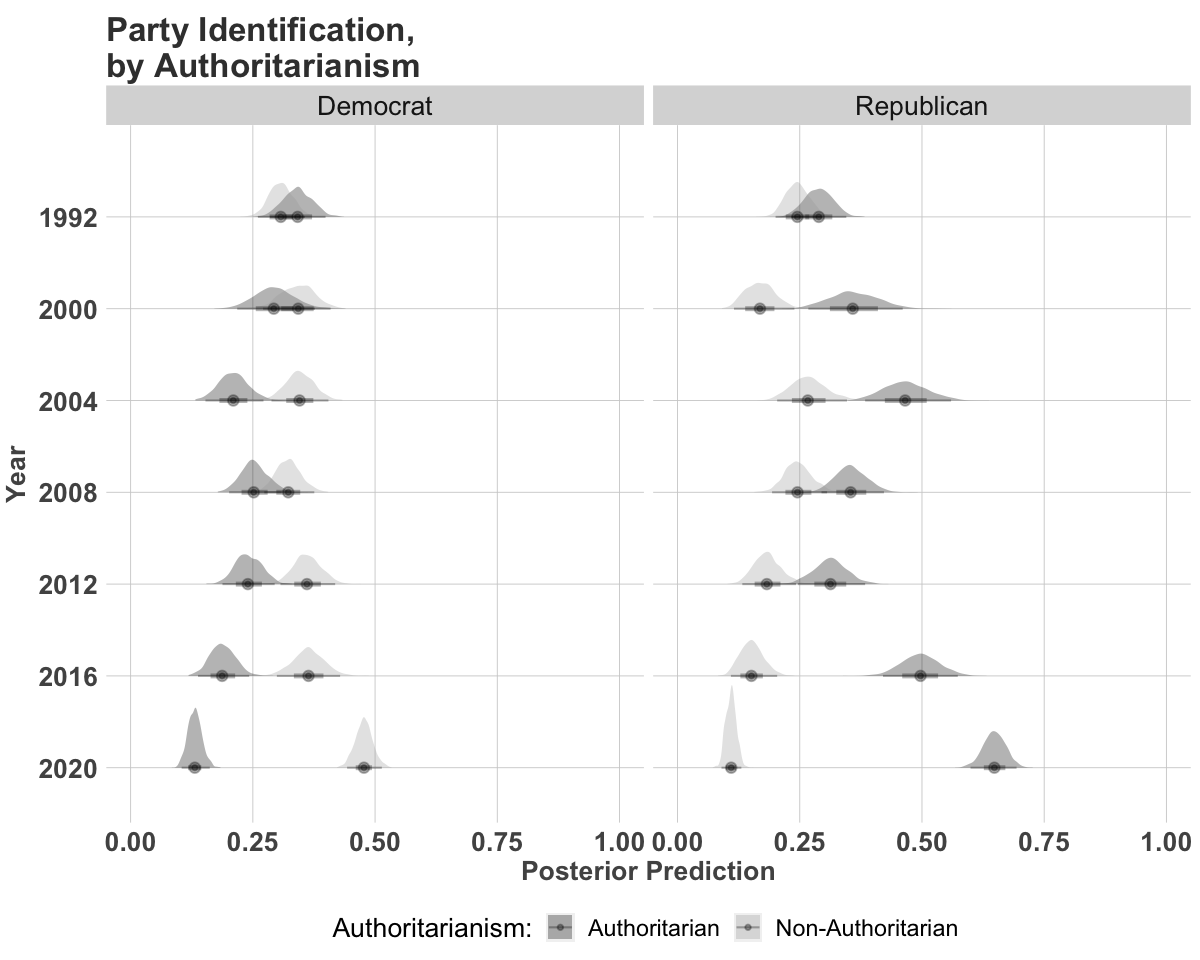

In [77]:
library(tidybayes)
options(repr.plot.width = 10, repr.plot.height = 8)

party <- party_model[[2]]
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_epred_draws(party) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  subset(.category != 2) %>%
  ggplot(aes(
    x = .epred, y = as.factor(year),
    group = as.factor(authoritarianism), fill = Authoritarianism
  )) +
  facet_wrap(~PID) +
  stat_halfeye(alpha = 0.3) +
  ggtheme +
  # Format the grid
  ggtitle("Party Identification,\nby Authoritarianism") +
  scale_x_continuous("Posterior Prediction", limits = c(0, 1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name = "Authoritarianism:", values = c("black", "darkgrey")) +
  theme(legend.position = "bottom")


In [38]:
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(party) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  subset(.category != 2) %>%
  group_by(.category, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.epred, prob = 0.5),
    min = quantile(.epred, prob = 0.025),
    max = quantile(.epred, prob = 0.975)
  )


`summarise()` has grouped output by '.category', 'Authoritarianism'. You can
override using the `.groups` argument.


.category,Authoritarianism,year,mean,min,max
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Authoritarian,1992,0.3362061,0.2856333,0.3891394
1,Authoritarian,2000,0.2796697,0.2119778,0.3639009
1,Authoritarian,2004,0.2049155,0.1528695,0.2673726
1,Authoritarian,2008,0.2449668,0.1959167,0.2980067
1,Authoritarian,2012,0.2314080,0.1812077,0.2859113
1,Authoritarian,2016,0.1830142,0.1334741,0.2381879
1,Authoritarian,2020,0.1273561,0.1025013,0.1575318
1,Non-Authoritarian,1992,0.3061003,0.2554954,0.3527083
1,Non-Authoritarian,2000,0.3429039,0.2696860,0.4097055


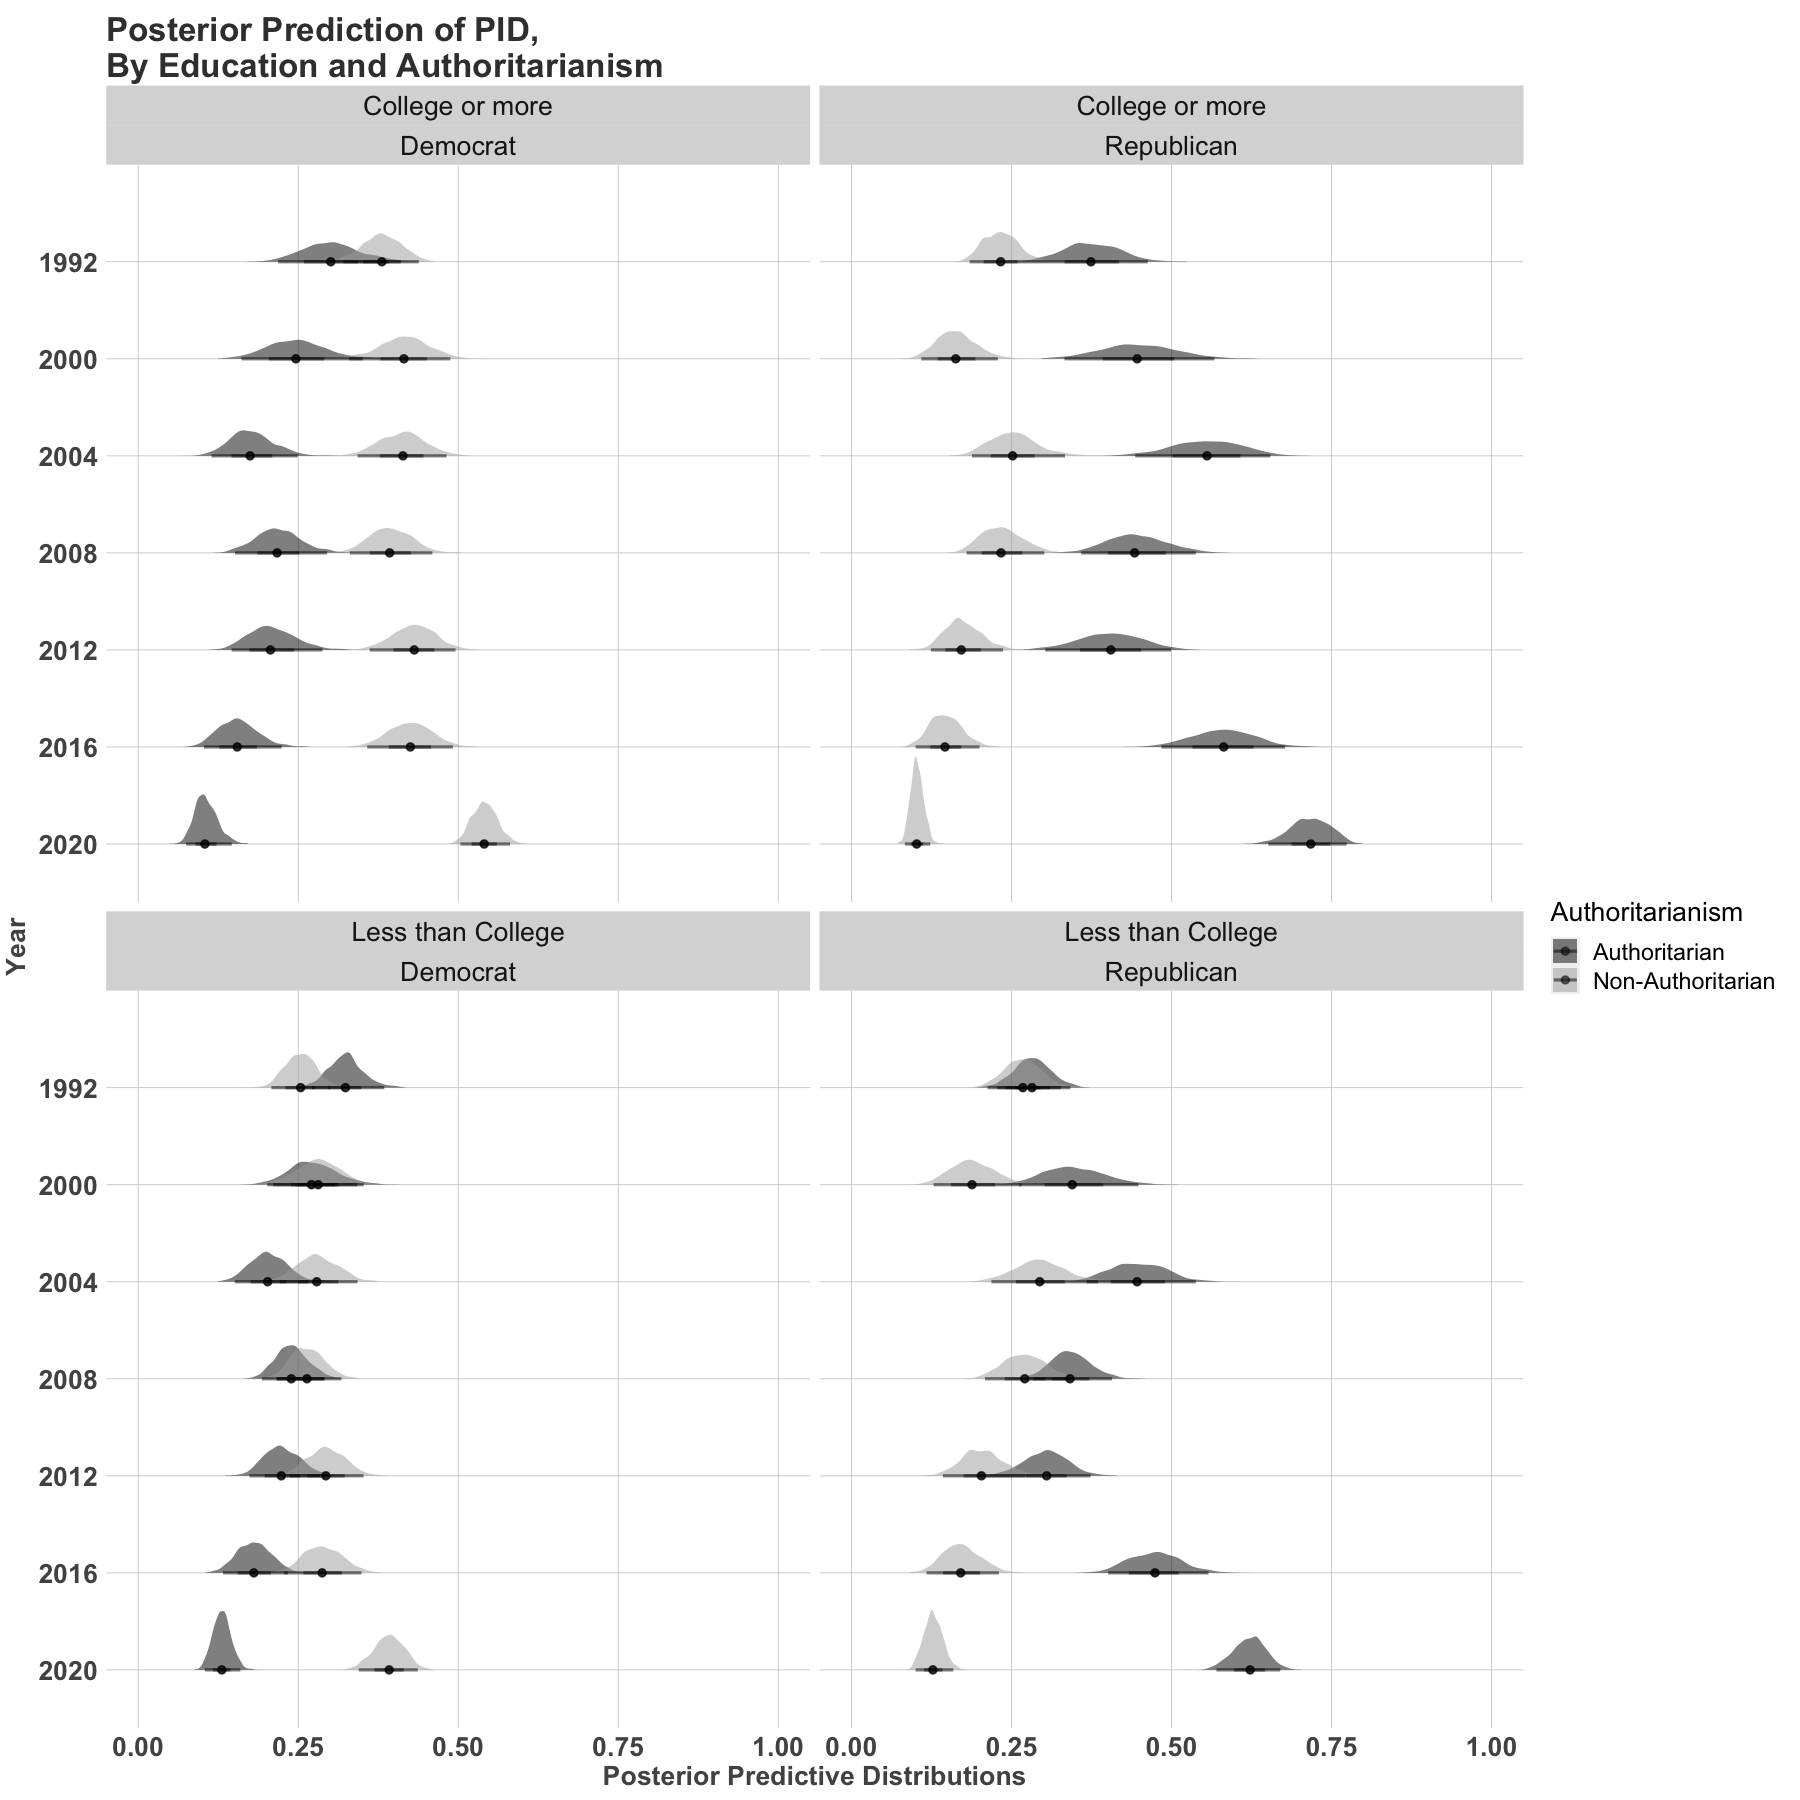

In [60]:
options(repr.plot.width = 13, repr.plot.height = 10)

partyXed <- party_model[[1]]
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_epred_draws(partyXed) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  subset(.category != 2) %>%
  ggplot(aes(
    x = .epred, y = as.factor(year),
    group = as.factor(authoritarianism),
    fill = Authoritarianism
  )) +
  facet_wrap(~ Education + PID) +
  stat_halfeye(alpha = 0.5, size = 3) +
  ggtheme +
  # Format the grid
  ggtitle("Posterior Prediction of PID,\nBy Education and Authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits = c(0, 1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name = "Authoritarianism", values = c("black", "darkgrey"))


The effect of authoritarianism among the on-college educated only begin to emerge in 2016. Here's another interesting graph. Authoritarianism has a relatively flat effect in 2012, 2008.


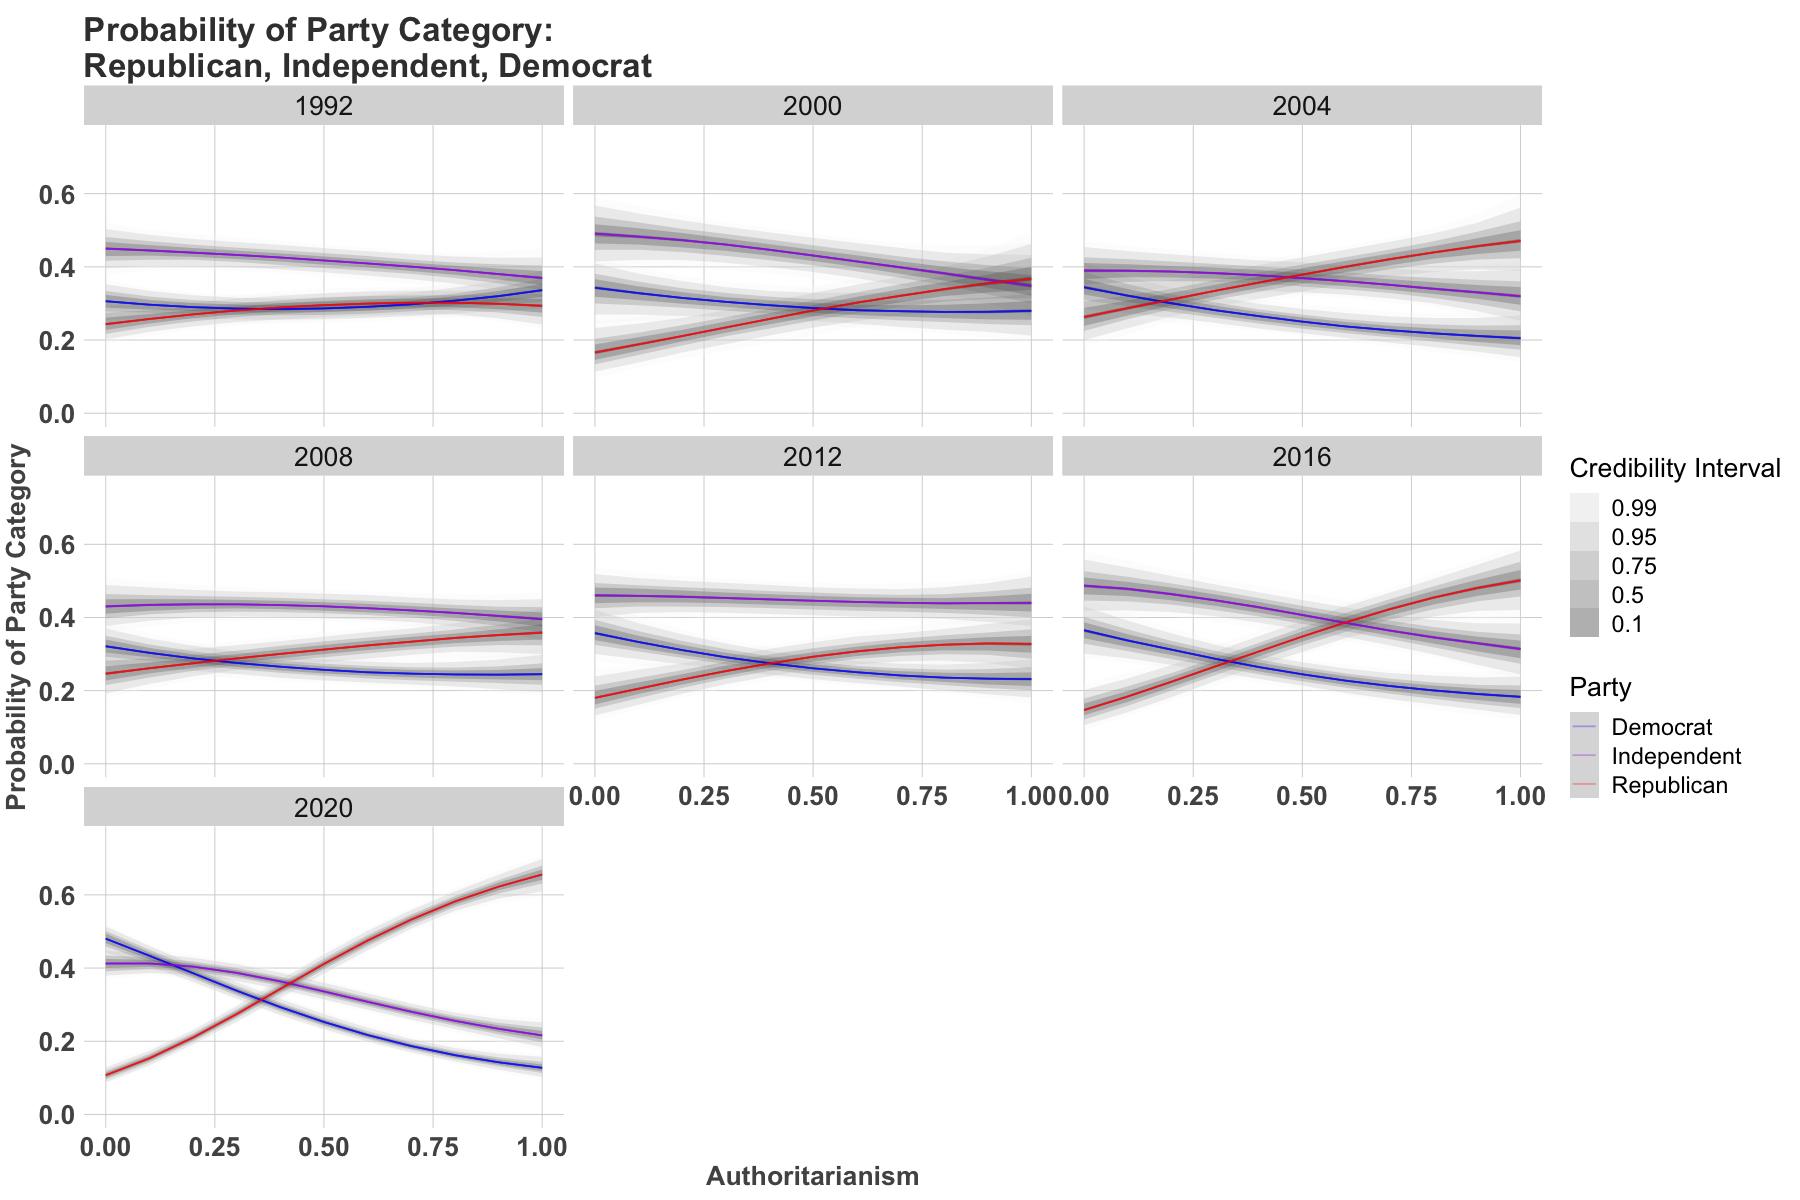

In [32]:
options(repr.plot.width = 15, repr.plot.height = 10)

fixed_data %>%
    group_by(year) %>%
    data_grid(
        female = mean(female), age = mean(age),
        college = mean(college), income = mean(income),
        catholic = mean(catholic), jewish = mean(jewish),
        other = mean(other),
        authoritarianism = seq_range(authoritarianism, n = 11)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    group_by(year) %>%
    add_epred_draws(party) %>%
    mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
    #       subset(.category != 2)  %>%
    ggplot(aes(x = authoritarianism, color = PID)) +
    facet_wrap(~year) +
    stat_lineribbon(aes(y = .epred), .width = c(.1, .5, 0.75, 0.95, 0.99), size = 0.5, alpha = 0.3) +
    scale_color_manual(name = "Party", values = c("blue", "purple", "red")) +
    ggtheme +
    scale_fill_brewer(name = "Credibility Interval", palette = "Greys") +

    # Format the grid
    ggtitle("Probability of Party Category:\nRepublican, Independent, Democrat") +
    scale_y_continuous("Probability of Party Category", limits = c(0, 0.75)) +
    scale_x_continuous("Authoritarianism")


Authoritarians clearly shift to the Republican Party, but really only in 2004, and then again in 2016, 2020.

# Mediation and Moderation

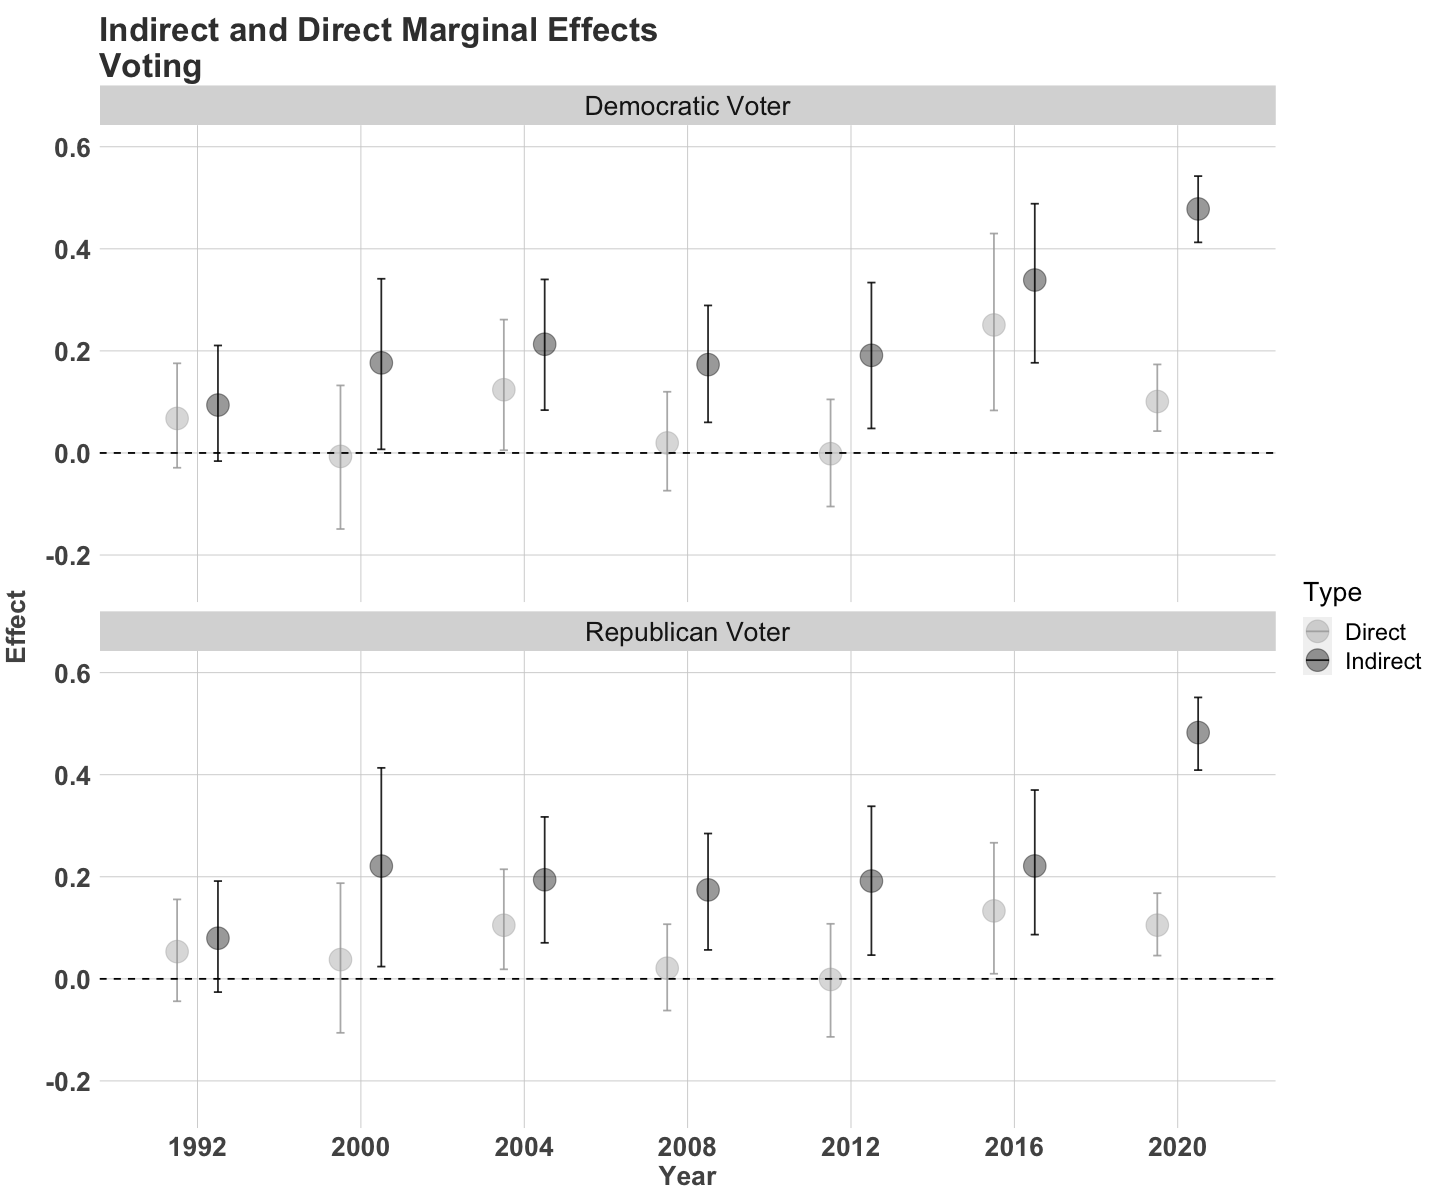

In [94]:


options(repr.plot.width = 12, repr.plot.height = 10)
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter6/indirect.rda")

plt <- a[[1]]
plt$type <- ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party <- ifelse(grepl("*_0", row.names(plt)), "Democratic Voter", "Republican Voter")
plt$year <- rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each = 4)
plt %>% ggplot(aes(
  x = factor(year),
  y = mean, ymin = X2.5.,
  ymax = X97.5., colour = as.factor(type), group = as.factor(type)
)) +
  facet_wrap(~party, nrow = 2) +
  geom_point(size = 6, alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Indirect and Direct Marginal Effects\nVoting") +
  ggtheme +
  scale_y_continuous("Effect", limits = c(-0.25, 0.6)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Type", values = c("darkgrey", "black"))


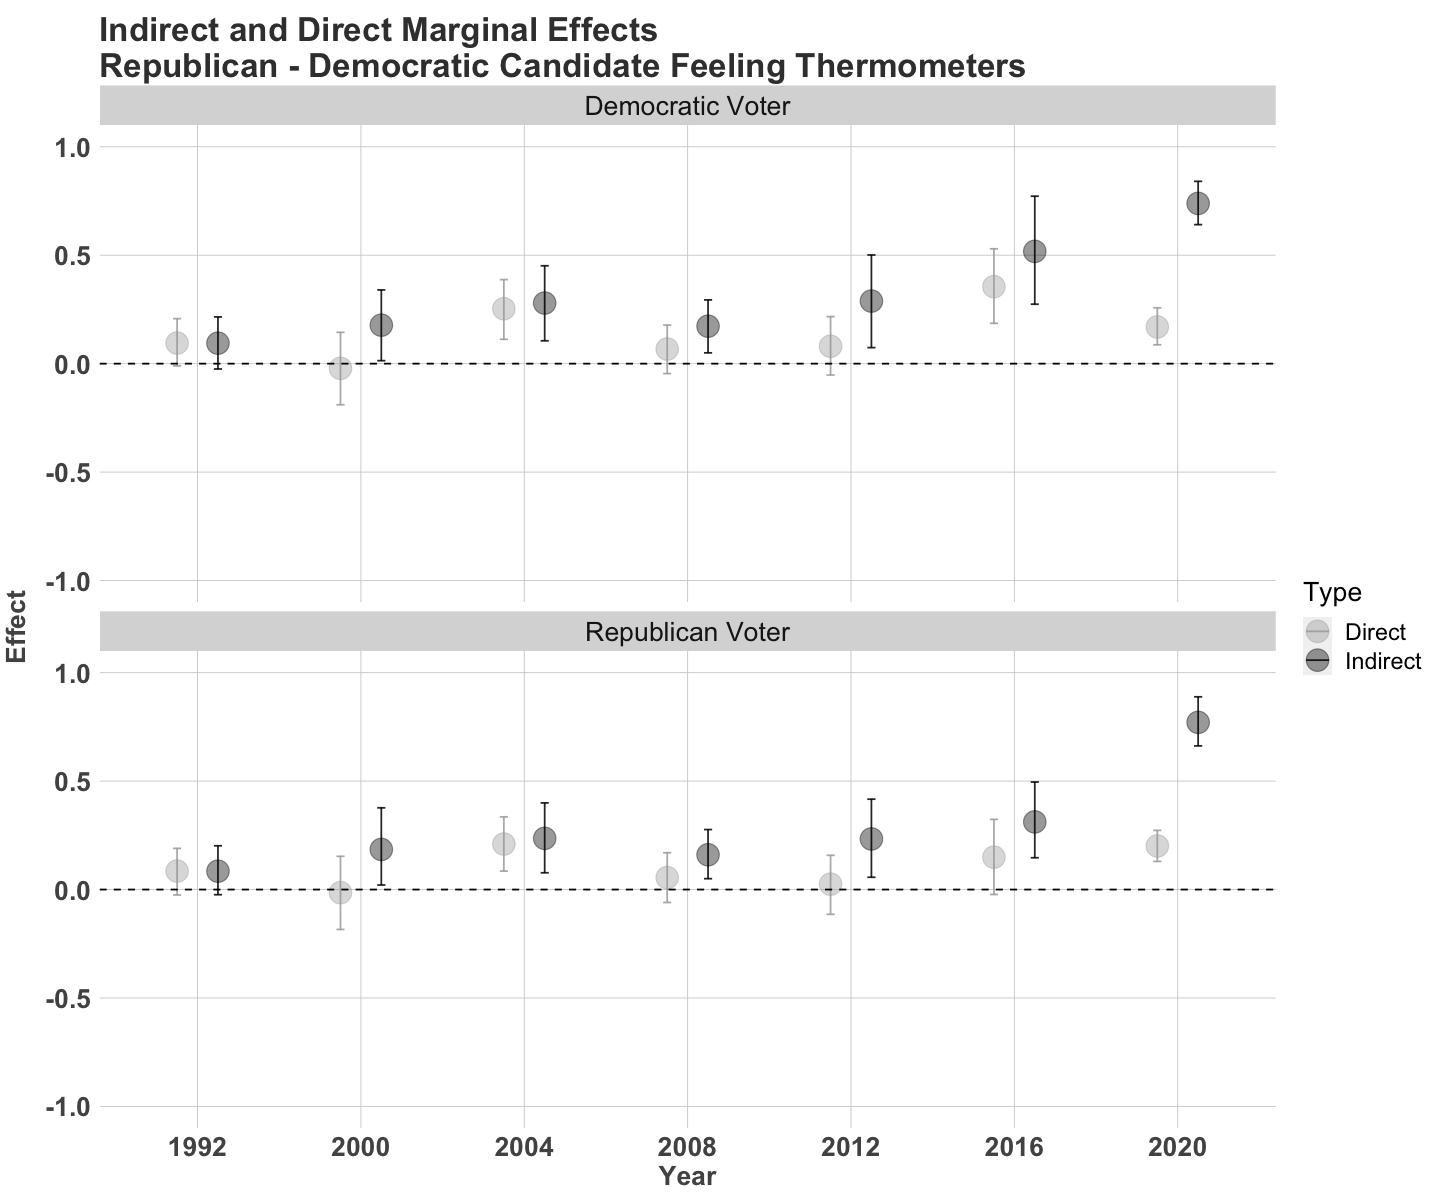

In [96]:
plt <- a[[2]]
plt$type <- ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party <- ifelse(grepl("*_0", row.names(plt)), "Democratic Voter", "Republican Voter")
plt$year <- rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each = 4)
plt %>% ggplot(aes(
  x = factor(year),
  y = mean, ymin = X2.5.,
  ymax = X97.5., colour = as.factor(type), group = as.factor(type)
)) +
  facet_wrap(~party, nrow = 2) +
  geom_point(size = 6, alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Indirect and Direct Marginal Effects\nRepublican - Democratic Candidate Feeling Thermometers") +
  ggtheme +
  scale_y_continuous("Effect", limits = c(-1, 1)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Type", values = c("darkgrey", "black"))
